In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in Python modules
import datetime
import inspect
import os
import csv

# Python add-ons
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates as mpl_dates
from scipy import stats

# For accessing UNIDATA THREDDS servers
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

# Sandia PVLIB-Python Module
import pvlib
from pvlib import solarposition, irradiance, atmosphere, pvsystem

# Sandia PVLIB-Python Forecasting Class
from pvlib.forecast import GFS, HRRR_ESRL, NAM, NDFD, HRRR, RAP

# Sandia PVLIB-Python Location Class
from pvlib.location import Location

# Sandia PVLIB-Python PV Power Classes
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/forecast.py:21: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The API may change, the functionality may be consolidated into an io ' +


In [2]:
latitude = 4.6024
longitude = -74.0674
tz = 'America/Bogota' #Time Zone at Bogotá, Colombia

#start = pd.Timestamp(pd.datetime.now(), tz=tz) # Today's date
#end = start + pd.Timedelta(days=-7) # 7 days back from today

start = pd.Timestamp('2020-06-15', tz=tz) # Start of Init-May (May 05, 2020)
end = pd.Timestamp('2020-06-21', tz=tz) # End of Init-May (May 11, 2020)

location = Location(latitude, longitude, tz, altitude=2624)

___
# SECTION 1: Detailed Week Information

In [3]:
file_name = '/Users/nelsonsasa07/Documents/PV Simulations/CNO/CNO_Data_Detailed.xlsx'

#Meteocontrol Irradiance Measurement
irrad_sheet = 'Radiacin_2020_06'
measured_irrad = pd.read_excel(io=file_name, sheet_name=irrad_sheet)
measured_irrad = pd.DataFrame(measured_irrad)

#Meteocontrol DC Voltage Measurement
dcvoltage_sheet = 'Tensin_DC_2020_06'
measured_dcvoltage = pd.read_excel(io=file_name, sheet_name=dcvoltage_sheet)
measured_dcvoltage = pd.DataFrame(measured_dcvoltage)

#Meteocontrol DC Current Measurement
dccurrent_sheet = 'Corriente_DC_2020_06'
measured_dccurrent = pd.read_excel(io=file_name, sheet_name=dccurrent_sheet)
measured_dccurrent = pd.DataFrame(measured_dccurrent)

#Meteocontrol DC Power Measurement
dcpower_sheet = 'Potencia_DC_2020_06'
measured_dcpower = pd.read_excel(io=file_name, sheet_name=dcpower_sheet)
measured_dcpower = pd.DataFrame(measured_dcpower)

#Meteocontrol AC Power Measurement
acpower_sheet = 'Potencia_AC_2020_06'
measured_acpower = pd.read_excel(io=file_name, sheet_name=acpower_sheet)
measured_acpower = pd.DataFrame(measured_acpower)

#Meteocontrol Module Temperature Measurement
modtemp_sheet = 'Temperatura-Energa_2020_06'
measured_modtemp = pd.read_excel(io=file_name, sheet_name=modtemp_sheet)
measured_modtemp = pd.DataFrame(measured_modtemp)

#Meteocontrol Energy Measurement
energy_sheet = 'Energa_2020_06'
measured_energy = pd.read_excel(io=file_name, sheet_name=energy_sheet)
measured_energy = pd.DataFrame(measured_energy)

In [4]:
new_irrad = []
for data in measured_irrad['Meteocontrol Irrad., W/m2']:
    if data <= 1.8:
        new_irrad.append(0)
    else:
        new_irrad.append(data)

new_irrad = pd.DataFrame(new_irrad)

new_irrad = new_irrad.set_index(measured_irrad.index)

measured_irrad['New Meteo. Irrad., W/m2'] = new_irrad

In [5]:
# Get the Inversors Characteristics from the Database Selected
# There is two modules due to the fact that the University Solar Park is compound by two different systems
# The user can check the databases here: https://github.com/BreakingBytes/simkit/tree/master/examples/PVPower/pvpower

inverters_database = 'CECInverter';

inverters = retrieve_sam(inverters_database);
inverter_A = inverters.ABB__TRIO_50_0_TL_OUTD_US_480__480V__480V__CEC_2018_; #51.24 kWp System
inverter_B = inverters.ABB__TRIO_27_6_TL_OUTD_S_US_480__480V__480V__CEC_2018_; #28.82 kWp System

In [6]:
# Name,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,I_mp_ref,V_mp_ref,alpha_sc,beta_oc,T_NOCT,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
# LG Electronics Inc. LG400N2W-A5,Mono-c-Si,0,400.316000,368.400000,2,2,1,72,10.470000,49.300000,9.860000,40.600000,0.003141,-0.128180,47.700000,1.821208,10.481150,1.807477e-11,0.312859,293.805420,9.380614,-0.360000,N,SAM 2018.11.11 r2,1/3/2019

LG400N2WA5 = {
'BIPV':                'N',
'Date':          '1/3/2019',
'T_NOCT':             47.7,
'A_c':                 2.0,
'N_s':                  72,
'I_sc_ref':          10.47,
'V_oc_ref':           49.3,
'I_mp_ref':           9.86,
'V_mp_ref':           40.6,
'alpha_sc':       0.003141,
'beta_oc':        -0.12180,
'a_ref':            1.821208,
'I_L_ref':          10.481150,
'I_o_ref':         1.807477e-11,
'R_s':               0.312859,
'R_sh_ref':         293.805420,
'Adjust':            9.380614,
'gamma_r':          -0.36,
'Version':          'NRELv1',
'PTC':               368.4,
'Technology':    'Mono-c-Si',
'Name': 'LG Electronics LG400N2W-A5',
    
#PVSyst Required Variables
'gamma_ref':         1.013, #Diode Quality Factor, Value from PVSyst    
'mu_gamma':          0, #PVSyst specify that mono-cSi modules mu_gamma is very close to zero
'R_sh_0':            3500, #Resistance shunt at 0 irrad., Value from PVSyst                                                           
'R_sh_exp':          5.5, #Experimental resistance shunt, Value from PVSyst
'cells_in_series':  72,    
'EgRef':            1.121,

#PVWatts Required Variables   
'pdc0':              400.316, #Value from PVWatts API and validated with PVSyst API
'gamma_pdc':        -0.0036 #Value from PVWatts API and validated with PVSyst API
}

module = pd.Series(LG400N2WA5, name='LG_Electronics_LG400N2W_A5')

In [7]:
# Definition of the Los Andes Photovoltaic Systems

LosAndesSys = 'Los Andes 80 kWp System';

#System A
sysA_name = 'Los Andes 51.25 kWp System Capacity';
mps_SysA = 16; #Modules Per String
spi_SysA = 8; #Strings Per Inverter

system_A = PVSystem(module_parameters=module, inverter_parameters=inverter_A, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=mps_SysA, strings_per_inverter=spi_SysA)

#System B
sysB_name = 'Los Andes 28.82 kWp System Capacity';
mps_SysB = 18; #Modules Per String
spi_SysB = 4; #Strings Per Inverter
system_B = PVSystem(module_parameters=module, inverter_parameters=inverter_B, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=mps_SysB, strings_per_inverter=spi_SysB)

### 1.1. PVLIB Model Initialization

In [1]:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_cec(measured_irrad['New Meteo. Irrad., W/m2'],
                                                     measured_modtemp['Modules Temp., °C'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     Adjust=9.380614,
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info = pvsystem.singlediode(photocurrent=IL,
                                  saturation_current=I0,
                                  resistance_series=Rs,
                                  resistance_shunt=Rsh,
                                  nNsVth=nNsVth,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# Scalating CEC et. al. Single Diode Results
data_i_sc = pd.Series(curve_info['i_sc'])
data_v_oc = pd.Series(curve_info['v_oc'])
data_i_mp = pd.Series(curve_info['i_mp'])
data_v_mp = pd.Series(curve_info['v_mp'])
data_p_mp = pd.Series(curve_info['p_mp'])
data_i_x = pd.Series(curve_info['i_x'])
data_i_xx = pd.Series(curve_info['i_xx'])

results_general = pd.DataFrame({'i_sc': data_i_sc, 
                        'v_oc': data_v_oc,
                        'i_mp': data_i_mp, 
                        'v_mp': data_v_mp, 
                        'p_mp': data_p_mp, 
                        'i_x': data_i_x,
                        'i_xx': data_i_xx})

year = start.year
month = start.month
str_date = []

for day, hour in list(zip(measured_irrad['Day'], measured_irrad['Hour'])):
    if day < 10 and month < 10:
        str_date.append('{}-0{}-0{} {}'.format(year, month, day, hour))
    else:
        str_date.append('{}-{}-{} {}'.format(year, month, day, hour))

datetime_index = str_date

sc_SysA = system_A.scale_voltage_current_power(results_general)
sc_SysA['Datetime'] = pd.to_datetime(datetime_index)
sc_SysA = sc_SysA.set_index('Datetime')

sc_SysB = system_B.scale_voltage_current_power(results_general)
sc_SysB['Datetime'] = pd.to_datetime(datetime_index)
sc_SysB = sc_SysB.set_index('Datetime')

NameError: name 'pvsystem' is not defined

In [9]:
sc_SysA

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
Datetime,,,,,,,
2020-06-15 00:00:00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
2020-06-15 00:05:00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
2020-06-15 00:10:00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
2020-06-15 00:15:00,3.231174e-27,0.0,3.231174e-27,0.0,0.0,3.231174e-27,3.231174e-27
2020-06-15 00:20:00,1.615587e-27,0.0,1.615587e-27,0.0,0.0,1.615587e-27,1.615587e-27
...,...,...,...,...,...,...,...
2020-06-21 23:35:00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
2020-06-21 23:40:00,-1.615587e-27,0.0,-1.615587e-27,0.0,-0.0,-1.615587e-27,-1.615587e-27
2020-06-21 23:45:00,-1.615587e-27,0.0,-1.615587e-27,0.0,-0.0,-1.615587e-27,-1.615587e-27


In [10]:
#Setting Datetime-Index for Measured Irrad.
measured_irrad['Datetime'] = pd.to_datetime(datetime_index)
measured_irrad = measured_irrad.set_index('Datetime')

#Setting Datetime-Index for Measured Modules Temp.
measured_modtemp['Datetime'] = pd.to_datetime(datetime_index)
measured_modtemp = measured_modtemp.set_index('Datetime')

In [11]:
max_irrad = measured_irrad['Meteocontrol Irrad., W/m2'].resample('1d').max();

max_location = measured_irrad['Meteocontrol Irrad., W/m2'].resample('1d').apply(lambda s: s.idxmax());

max_temp_cell = measured_modtemp['Modules Temp., °C'].resample('1d').max();

cases = list(zip(max_location.values, max_irrad.values, max_temp_cell.values));
conditions = pd.DataFrame(cases, columns=['Datetime', 'Geff', 'Tcell']);
conditions = conditions.round(2);
conditions.head()

,Datetime,Geff,Tcell
0,2020-06-15 10:55:00,1079.88,44.10
1,2020-06-16 12:20:00,919.47,49.55
2,2020-06-17 12:10:00,730.94,37.37
3,2020-06-18 13:45:00,736.80,32.05
4,2020-06-19 13:45:00,792.98,41.78


In [12]:
IL_CEC, I0_CEC, Rs_CEC, Rsh_CEC, nNsVth_CEC = pvsystem.calcparams_cec(conditions['Geff'],
                                                     conditions['Tcell'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     Adjust=9.380614,
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info_CEC = pvsystem.singlediode(photocurrent=IL_CEC,
                                  saturation_current=I0_CEC,
                                  resistance_series=Rs_CEC,
                                  resistance_shunt=Rsh_CEC,
                                  nNsVth=nNsVth_CEC,
                                  ivcurve_pnts=100,
                                  method='lambertw')

### 1.2. I-V Curve

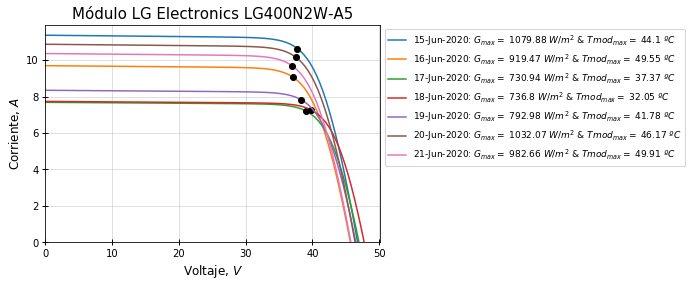

    i_sc   v_oc   i_mp   v_mp    p_mp    i_x  i_xx
0  11.36  46.76  10.63  37.74  401.29  11.28  7.53
1   9.69  45.68   9.06  37.09  336.03   9.62  6.52
2   7.68  46.97   7.22  38.98  281.25   7.62  5.35
3   7.73  47.74   7.27  39.77  289.25   7.67  5.40
4   8.34  46.49   7.83  38.30  299.68   8.28  5.74
5  10.87  46.38  10.16  37.49  381.03  10.79  7.23
6  10.36  45.76   9.68  36.99  357.98  10.28  6.91


<Figure size 432x288 with 0 Axes>

In [13]:
# I-V Curves Plot
plt.style.use('fast')
plt.rc('font', family='Helvetica')
plt.figure()
                                                     
for i, case in conditions.iterrows():
    label = (
        f"{case['Datetime'].strftime('%d-%b-%Y')}: "
        "$G_{max} = $ " + f"{case['Geff']} $W/m^2$ & "
        "$Tmod_{max} = $ " + f"{case['Tcell']} $ºC$")
    
    plt.plot(curve_info_CEC['v'][i], curve_info_CEC['i'][i], label=label)
    v_mp = curve_info_CEC['v_mp'][i]
    i_mp = curve_info_CEC['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)
                                                     
plt.title('Módulo ' + LG400N2WA5['Name'], fontname="Helvetica", fontsize=15);
plt.ylabel('Corriente, $A$', fontname="Helvetica", fontsize=12);
plt.xlabel('Voltaje, $V$', fontname="Helvetica", fontsize=12);
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_IV_Curves.eps', bbox_inches='tight') 
plt.show()
plt.gcf().set_tight_layout(True)

data_summary_CEC = pd.DataFrame({'i_sc': curve_info_CEC['i_sc'],
                                'v_oc': curve_info_CEC['v_oc'],
                                'i_mp': curve_info_CEC['i_mp'],
                                'v_mp': curve_info_CEC['v_mp'],
                                'p_mp': curve_info_CEC['p_mp'],
                                'i_x': curve_info_CEC['i_x'],
                                'i_xx': curve_info_CEC['i_xx']})

data_summary_CEC = data_summary_CEC.round(2)
print(data_summary_CEC)

### 1.3. Losses

In [14]:
losses_pvw = pvsystem.pvwatts_losses(soiling=2, shading=3, snow=0, mismatch=2, wiring=2, 
                                       connections=0.5, lid=1.5, nameplate_rating=1, age=0, 
                                       availability=3)

losses = 26.9 #According to the paper Performance Parameters for Grid-Connected PV Systems by NREL
losses = losses/100

#Applying NREL PVWatts Losses Equation
derate_factor = 0.731 #Overall Derate Factor at NOCT
eta_inv_nom = 0.98184
derate = derate_factor/eta_inv_nom
percentage_error = (1-derate)*100

losses_pvw = percentage_error/100

#Losses System A
sc_SysA['i_mp'] = sc_SysA['i_mp'] - sc_SysA['i_mp']*losses
sc_SysA['p_mp'] = sc_SysA['p_mp'] - sc_SysA['p_mp']*losses

#Losses System B
sc_SysB['i_mp'] = sc_SysB['i_mp'] - sc_SysB['i_mp']*losses
sc_SysB['p_mp'] = sc_SysB['p_mp'] - sc_SysB['p_mp']*losses

### 1.4. PVWatts DC Model Initialization

In [15]:
#Variables Required for PVWatts_DC Function
eta_inv_nom = 0.98184; #CEC Weighted Efficiency, Value from PVWatts API
eta_inv_ref=0.986; #Value from PVWatts API
pdc0_inv = 50881.8; #Value from PVWatts API

#PVWatts DC Model
pvwatts_dc_model = pvsystem.pvwatts_dc(measured_irrad['New Meteo. Irrad., W/m2'], 
                                       measured_modtemp['Modules Temp., °C'], 
                                       pdc0=module['pdc0'], 
                                       gamma_pdc=module['gamma_pdc'], 
                                       temp_ref=25.0)

#Scalating PVWatts DC Model Results
pvwatts_dc_model_SysA = pvwatts_dc_model*mps_SysA*spi_SysA; #Scalated DC Power for SysA
pvwatts_dc_model_SysB = pvwatts_dc_model*mps_SysB*spi_SysB; #Scalated DC Power for SysB

#Decrease Due to Losses
pvwatts_dc_model_SysA = pvwatts_dc_model_SysA - pvwatts_dc_model_SysA*losses_pvw; #DC Power for SysA with Losses
pvwatts_dc_model_SysB = pvwatts_dc_model_SysB - pvwatts_dc_model_SysB*losses_pvw; #DC Power for SysA with Losses

### 1.5. PVSyst DC Model Initialization

In [16]:
IL_PVS, I0_PVS, Rs_PVS, Rsh_PVS, nNsVth_PVS = pvsystem.calcparams_pvsyst(measured_irrad['New Meteo. Irrad., W/m2'],
                                                     measured_modtemp['Modules Temp., °C'],
                                                     module['alpha_sc'],
                                                     module['gamma_ref'], #Diode Quality Factor, Value from PVSyst
                                                     module['mu_gamma'], #PVSyst specify that mono-cSi modules mu_gamma is very close to zero
                                                     I_L_ref=module['I_L_ref'],
                                                     I_o_ref=module['I_o_ref'],
                                                     R_sh_ref=module['R_sh_ref'],
                                                     R_sh_0=module['R_sh_0'], #Resistance shunt at 0 irrad., Value from PVSyst
                                                     R_s=module['R_s'],
                                                     cells_in_series=module['N_s'],
                                                     R_sh_exp=module['R_sh_exp'],
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     irrad_ref=1000, #Retrieved from last link at above description
                                                     temp_ref=25) #Retrieved from last link at above description

curve_info_PVS = pvsystem.singlediode(photocurrent=IL_PVS,
                                  saturation_current=I0_PVS,
                                  resistance_series=Rs_PVS,
                                  resistance_shunt=Rsh_PVS,
                                  nNsVth=nNsVth_PVS,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# Scalating PVSyst Single Diode Results
data_i_sc_PVS = pd.Series(curve_info_PVS['i_sc'])
data_v_oc_PVS = pd.Series(curve_info_PVS['v_oc'])
data_i_mp_PVS = pd.Series(curve_info_PVS['i_mp'])
data_v_mp_PVS = pd.Series(curve_info_PVS['v_mp'])
data_p_mp_PVS = pd.Series(curve_info_PVS['p_mp'])
data_i_x_PVS = pd.Series(curve_info_PVS['i_x'])
data_i_xx_PVS = pd.Series(curve_info_PVS['i_xx'])

results_general_PVS = pd.DataFrame({'i_sc': data_i_sc_PVS, 
                        'v_oc': data_v_oc_PVS,
                        'i_mp': data_i_mp_PVS, 
                        'v_mp': data_v_mp_PVS, 
                        'p_mp': data_p_mp_PVS, 
                        'i_x': data_i_x_PVS,
                        'i_xx': data_i_xx_PVS})

year = start.year
month = start.month
str_date_PVS = []

for day, hour in list(zip(measured_irrad['Day'], measured_irrad['Hour'])):
    if day < 10 and month < 10:
        str_date_PVS.append('{}-0{}-0{} {}'.format(year, month, day, hour))
    else:
        str_date_PVS.append('{}-{}-{} {}'.format(year, month, day, hour))

datetime_index = str_date_PVS

sc_SysA_PVS = system_A.scale_voltage_current_power(results_general_PVS)
sc_SysA_PVS['Datetime'] = pd.to_datetime(datetime_index)
sc_SysA_PVS = sc_SysA_PVS.set_index('Datetime')

sc_SysB_PVS = system_B.scale_voltage_current_power(results_general_PVS)
sc_SysB_PVS['Datetime'] = pd.to_datetime(datetime_index)
sc_SysB_PVS = sc_SysB_PVS.set_index('Datetime')

In [17]:
#Losses System A
sc_SysA_PVS['i_mp'] = sc_SysA_PVS['i_mp'] - sc_SysA_PVS['i_mp']*losses
sc_SysA_PVS['p_mp'] = sc_SysA_PVS['p_mp'] - sc_SysA_PVS['p_mp']*losses

#Losses System B
sc_SysB_PVS['i_mp'] = sc_SysB_PVS['i_mp'] - sc_SysB_PVS['i_mp']*losses
sc_SysB_PVS['p_mp'] = sc_SysB_PVS['p_mp'] - sc_SysB_PVS['p_mp']*losses

### 1.6. Detailed DC Voltage

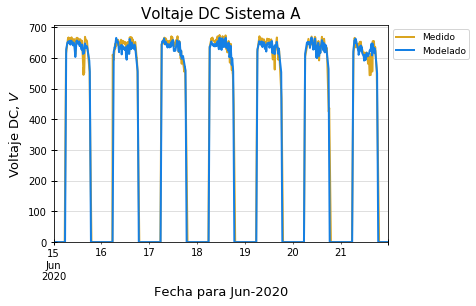

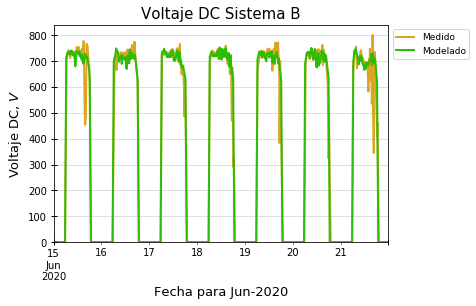

In [18]:
measured_dcvoltage = measured_dcvoltage.set_index(sc_SysA.index)

#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

measured_dcvoltage['DC Voltage SysA String 1, V'].plot(label='Medido', color='goldenrod', linewidth=2)
sc_SysA['v_mp'].plot(label='Modelado', color='#1580E4', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Voltaje DC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Voltaje DC, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Line_DCVol_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

measured_dcvoltage['DC Voltage SysB String 1, V'].plot(label='Medido', color='goldenrod', linewidth=2)
sc_SysB['v_mp'].plot(label='Modelado', color='#2DBD07', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Voltaje DC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Voltaje DC, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Line_DCVol_SysB.eps', bbox_inches='tight')

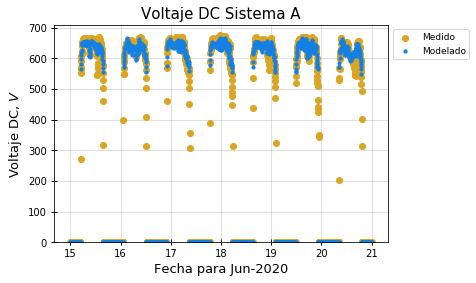

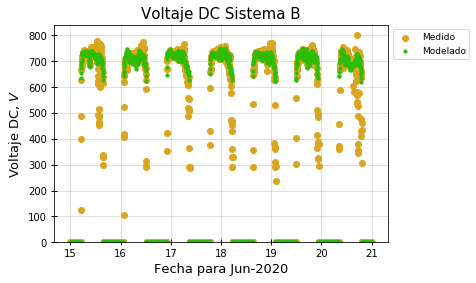

In [19]:
x_axis = np.linspace(int(start.day), int(end.day), int(len(sc_SysA['v_mp'])))

#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.scatter(x_axis, measured_dcvoltage['DC Voltage SysA String 1, V'], label='Medido', color='goldenrod')
plt.scatter(x_axis, sc_SysA['v_mp'], label='Modelado', color='#1580E4', s=10)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Voltaje DC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Voltaje DC, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Scatter_DCVol_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.scatter(x_axis, measured_dcvoltage['DC Voltage SysB String 1, V'], label='Medido', color='goldenrod')
plt.scatter(x_axis, sc_SysB['v_mp'], label='Modelado', color='#2DBD07', s=10)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Voltaje DC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Voltaje DC, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Scatter_DCVol_SysB.eps', bbox_inches='tight')

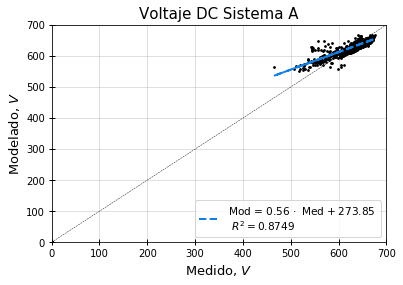

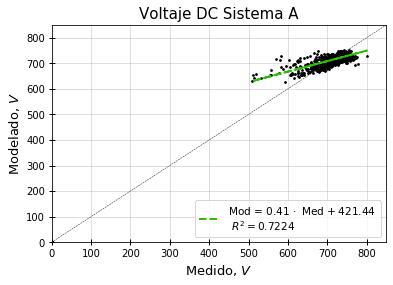

In [20]:
#System A
meas_voltage_SysA = []
sim_voltage_SysA = []

limvalue_SysA = 150

for i,j in list(zip(measured_dcvoltage['DC Voltage SysA String 1, V'], sc_SysA['v_mp'])):
    if i - j > limvalue_SysA or i - j < -limvalue_SysA:
        meas_voltage_SysA.append(0)
    else:
        meas_voltage_SysA.append(i)

for i,j in list(zip(measured_dcvoltage['DC Voltage SysA String 1, V'], sc_SysA['v_mp'])):
    if i - j > limvalue_SysA or i - j < -limvalue_SysA:
        sim_voltage_SysA.append(0)
    else:
        sim_voltage_SysA.append(j)

#Least Squares Linear Regression
x_value = []
y_value = []
for i,j in list(zip(meas_voltage_SysA, sim_voltage_SysA)):
    if i == 0 and j == 0:
        pass
    else:
        x_value.append(i)
        y_value.append(j)

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();

x = np.linspace(0, 700, 700)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Mod = " + f"{slope_SysA.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(meas_voltage_SysA, sim_voltage_SysA, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Voltaje DC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $V$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, 700);
plt.ylim(0, 700);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Comp_DC_Voltage_SysA.eps', bbox_inches='tight')

#System B
meas_voltage_SysB = []
sim_voltage_SysB = []

limvalue_SysB = 150

for i,j in list(zip(measured_dcvoltage['DC Voltage SysB String 1, V'], sc_SysB['v_mp'])):
    if i - j > limvalue_SysB or i - j < -limvalue_SysB:
        meas_voltage_SysB.append(0)
    else:
        meas_voltage_SysB.append(i)

for i,j in list(zip(measured_dcvoltage['DC Voltage SysB String 1, V'], sc_SysB['v_mp'])):
    if i - j > limvalue_SysB or i - j < -limvalue_SysB:
        sim_voltage_SysB.append(0)
    else:
        sim_voltage_SysB.append(j)

#Least Squares Linear Regression
x_value = []
y_value = []
for i,j in list(zip(meas_voltage_SysB, sim_voltage_SysB)):
    if i == 0 and j == 0:
        pass
    else:
        x_value.append(i)
        y_value.append(j)

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();

x = np.linspace(0, 850, 850)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Mod = " + f"{slope_SysB.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(meas_voltage_SysB, sim_voltage_SysB, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Voltaje DC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $V$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, 850);
plt.ylim(0, 850);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Comp_DC_Voltage_SysB.eps', bbox_inches='tight')

### 1.7. Detailed DC Current

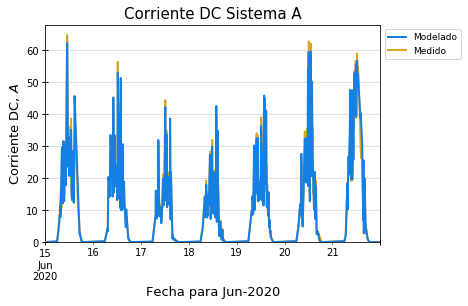

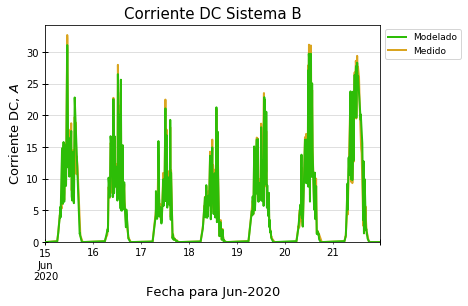

In [21]:
measured_dccurrent = measured_dccurrent.set_index(sc_SysA.index)

#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

sc_SysA['i_mp'].plot(label='Modelado', color='#1580E4', linewidth=2, zorder=5)
measured_dccurrent['DC Current SysA String 1, A'].plot(label='Medido', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Corriente DC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Corriente DC, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Line_DCCur_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

sc_SysB['i_mp'].plot(label='Modelado', color='#2DBD07', linewidth=2, zorder=5)
measured_dccurrent['DC Current SysB, A'].plot(label='Medido', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Corriente DC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Corriente DC, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Line_DCCur_SysB.eps', bbox_inches='tight')

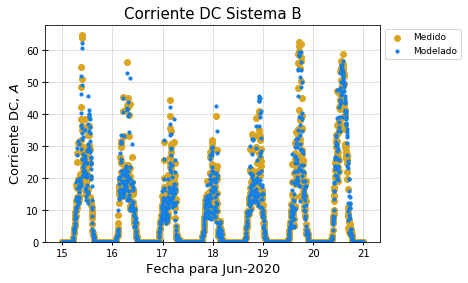

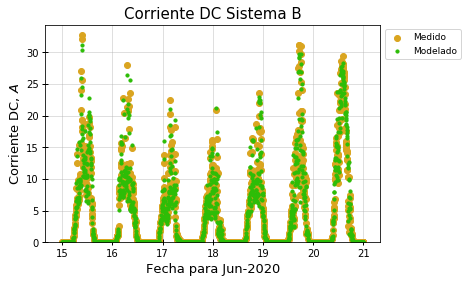

In [22]:
x_axis = np.linspace(int(start.day), int(end.day), int(len(sc_SysA['i_mp'])))

#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.scatter(x_axis, measured_dccurrent['DC Current SysA String 1, A'], label='Medido', color='goldenrod')
plt.scatter(x_axis, sc_SysA['i_mp'], label='Modelado', color='#1580E4', s=10)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Corriente DC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Corriente DC, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Scatter_DCCur_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.scatter(x_axis, measured_dccurrent['DC Current SysB, A'], label='Medido', color='goldenrod')
plt.scatter(x_axis, sc_SysB['i_mp'], label='Modelado', color='#2DBD07', s=10)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Corriente DC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Corriente DC, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Scatter_DCCur_SysB.eps', bbox_inches='tight')

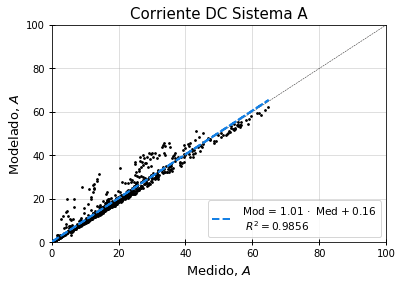

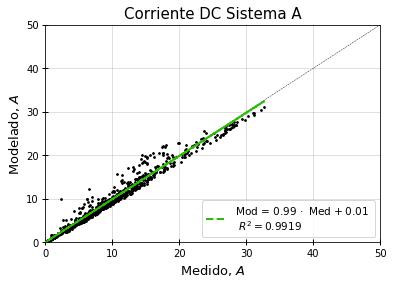

In [23]:
#System A
meas_current_SysA = []
sim_current_SysA = []

limvalue_SysA = 280

for i,j in list(zip(measured_dccurrent['DC Current SysA String 1, A'], sc_SysA['i_mp'])):
    if i - j > limvalue_SysA or i - j < -limvalue_SysA:
        meas_current_SysA.append(0)
    else:
        meas_current_SysA.append(i)

for i,j in list(zip(measured_dccurrent['DC Current SysA String 1, A'], sc_SysA['i_mp'])):
    if i - j > limvalue_SysA or i - j < -limvalue_SysA:
        sim_current_SysA.append(0)
    else:
        sim_current_SysA.append(j)

#Least Squares Linear Regression
x_value = []
y_value = []
for i,j in list(zip(meas_current_SysA, sim_current_SysA)):
    if i == 0 and j == 0:
        pass
    else:
        x_value.append(i)
        y_value.append(j)

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 100

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Mod = " + f"{slope_SysA.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(meas_current_SysA, sim_current_SysA, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Corriente DC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $A$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Comp_DC_Current_SysA.eps', bbox_inches='tight')

#System B
meas_current_SysB = []
sim_current_SysB = []

limvalue_SysB = 100

for i,j in list(zip(measured_dccurrent['DC Current SysB, A'], sc_SysB['i_mp'])):
    if i - j > limvalue_SysB or i - j < -limvalue_SysB:
        meas_current_SysB.append(0)
    else:
        meas_current_SysB.append(i)

for i,j in list(zip(measured_dccurrent['DC Current SysB, A'], sc_SysB['i_mp'])):
    if i - j > limvalue_SysB or i - j < -limvalue_SysB:
        sim_current_SysB.append(0)
    else:
        sim_current_SysB.append(j)

#Least Squares Linear Regression
x_value = []
y_value = []
for i,j in list(zip(meas_current_SysB, sim_current_SysB)):
    if i == 0 and j == 0:
        pass
    else:
        x_value.append(i)
        y_value.append(j)

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 50

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Mod = " + f"{slope_SysB.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(meas_current_SysB, sim_current_SysB, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Corriente DC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $A$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Comp_DC_Current_SysB.eps', bbox_inches='tight')

### 1.8. Detailed DC Power

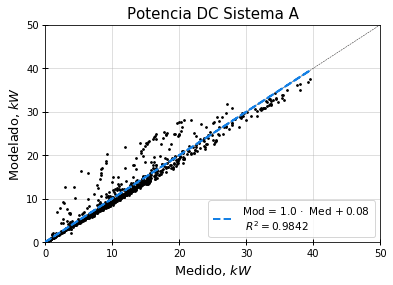

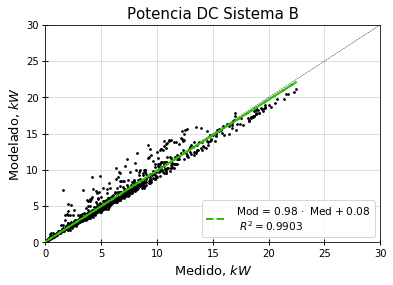

In [24]:
kilo = 1000;

#System A
#Least Squares Linear Regression
x_value = measured_dcpower['DC Power SysA String 1, W']/kilo
y_value = sc_SysA['p_mp']/kilo

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 50

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Mod = " + f"{slope_SysA.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_dcpower['DC Power SysA String 1, W']/kilo, sc_SysA['p_mp']/kilo, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Potencia DC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $kW$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Comp_DC_Power_SysA.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_dcpower['DC Power SysB, W']/kilo
y_value = sc_SysB['p_mp']/kilo

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 30

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Mod = " + f"{slope_SysB.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_dcpower['DC Power SysB, W']/kilo, sc_SysB['p_mp']/kilo, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Potencia DC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $kW$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Comp_DC_Power_SysB.eps', bbox_inches='tight')

### 1.9. Detailed AC Power

In [25]:
#Losses System A
sc_SysA['v_mp'] = sc_SysA['v_mp'] - sc_SysA['v_mp']*losses
sc_SysB['v_mp'] = sc_SysB['v_mp'] - sc_SysB['v_mp']*losses

ACPow_SysA = pvsystem.snlinverter(sc_SysA['v_mp'], sc_SysA['p_mp'], inverter_A)/kilo;
ACPow_SysB = pvsystem.snlinverter(sc_SysB['v_mp'], sc_SysB['p_mp'], inverter_B)/kilo;

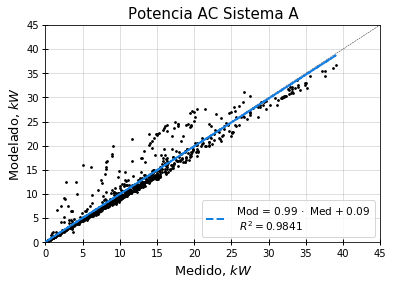

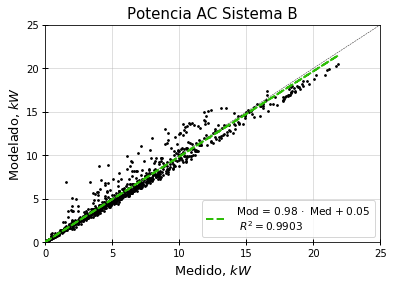

In [26]:
#System A
#Least Squares Linear Regression
x_value = measured_acpower['AC Power SysA, W']/kilo
y_value = ACPow_SysA

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 45

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Mod = " + f"{slope_SysA.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_acpower['AC Power SysA, W']/kilo, ACPow_SysA, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Potencia AC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $kW$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Comp_AC_Power_SysA.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_acpower['AC Power SysB, W']/kilo
y_value = ACPow_SysB

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 25

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Mod = " + f"{slope_SysB.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_acpower['AC Power SysB, W']/kilo, ACPow_SysB, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Potencia AC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $kW$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Comp_AC_Power_SysB.eps', bbox_inches='tight')

##### 1.9.1. Detailed AC Power for PVLIB, PVWatts and PVSyst

In [27]:
#PVWatts AC Model
pvwatts_ac_model_SysA = pvsystem.pvwatts_ac(pdc=pvwatts_dc_model_SysA,
                                       pdc0=pdc0_inv, 
                                       eta_inv_nom=eta_inv_nom, 
                                       eta_inv_ref=eta_inv_ref)

pvwatts_ac_model_SysB = pvsystem.pvwatts_ac(pdc=pvwatts_dc_model_SysB,
                                       pdc0=pdc0_inv, 
                                       eta_inv_nom=eta_inv_nom, 
                                       eta_inv_ref=eta_inv_ref)

#Changing NaN Values from Both Arrays to Zero (To Avoid Setbacks)
pvwatts_ac_model_SysA = pvwatts_ac_model_SysA.fillna(0);
pvwatts_ac_model_SysB = pvwatts_ac_model_SysB.fillna(0);

#PVSyst Voltage Losses
sc_SysA_PVS['v_mp'] = sc_SysA_PVS['v_mp'] - sc_SysA_PVS['v_mp']*losses
sc_SysB_PVS['v_mp'] = sc_SysB_PVS['v_mp'] - sc_SysB_PVS['v_mp']*losses

#PVSyst AC Model
ACPow_SysA_PVS = pvsystem.snlinverter(sc_SysA_PVS['v_mp'], sc_SysA_PVS['p_mp'], inverter_A)/kilo;
ACPow_SysB_PVS = pvsystem.snlinverter(sc_SysB_PVS['v_mp'], sc_SysB_PVS['p_mp'], inverter_B)/kilo;

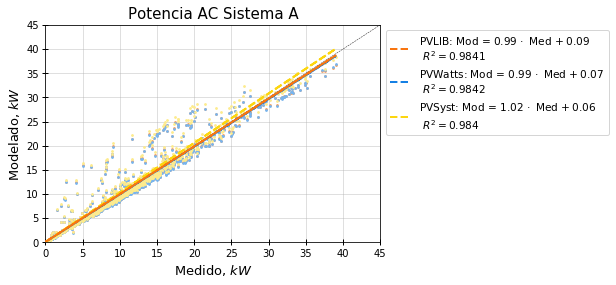

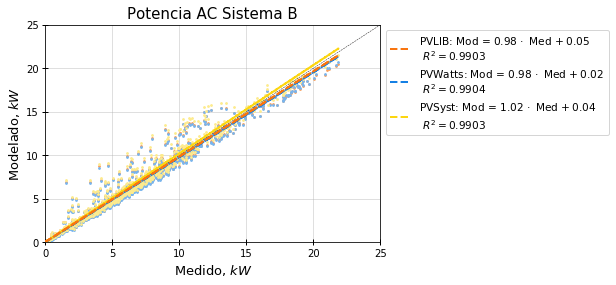

In [28]:
#System A
#Least Squares Linear Regression
x_value = measured_acpower['AC Power SysA, W']/kilo
y_value_PVL = ACPow_SysA
y_value_PVW = pvwatts_ac_model_SysA/kilo
y_value_PVS = ACPow_SysA_PVS

coef_SysA_PVL = np.polyfit(x_value, y_value_PVL, 1)
coef_SysA_PVW = np.polyfit(x_value, y_value_PVW, 1)
coef_SysA_PVS = np.polyfit(x_value, y_value_PVS, 1)

poly1d_fn_SysA_PVL = np.poly1d(coef_SysA_PVL)
poly1d_fn_SysA_PVW = np.poly1d(coef_SysA_PVW)
poly1d_fn_SysA_PVS = np.poly1d(coef_SysA_PVS)

slope_SysA_PVL, intercept_SysA_PVL, r_value_SysA_PVL, p_value_SysA_PVL, std_err_SysA_PVL = stats.linregress(x_value, y_value_PVL)
slope_SysA_PVW, intercept_SysA_PVW, r_value_SysA_PVW, p_value_SysA_PVW, std_err_SysA_PVW = stats.linregress(x_value, y_value_PVW)
slope_SysA_PVS, intercept_SysA_PVS, r_value_SysA_PVS, p_value_SysA_PVS, std_err_SysA_PVS = stats.linregress(x_value, y_value_PVS)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA_PVL = [slope_SysA_PVL, intercept_SysA_PVL, r_value_SysA_PVL, p_value_SysA_PVL, std_err_SysA_PVL]
data_result_SysA_PVW = [slope_SysA_PVW, intercept_SysA_PVW, r_value_SysA_PVW, p_value_SysA_PVW, std_err_SysA_PVW]
data_result_SysA_PVS = [slope_SysA_PVS, intercept_SysA_PVS, r_value_SysA_PVS, p_value_SysA_PVS, std_err_SysA_PVS]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 45

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA_PVL*x + intercept_SysA_PVL

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("PVLIB: Mod = " + f"{slope_SysA_PVL.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysA_PVL.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA_PVL.round(4)}"), color='#F87510', linewidth=2, zorder = 15)

plt.plot(x_value, poly1d_fn_SysA_PVW(x_value), '--k',
         label=("PVWatts: Mod = " + f"{slope_SysA_PVW.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysA_PVW.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA_PVW.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.plot(x_value, poly1d_fn_SysA_PVS(x_value), '--k',
         label=("PVSyst: Mod = " + f"{slope_SysA_PVS.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysA_PVS.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA_PVS.round(4)}"), color='#FCD610', linewidth=2, zorder = 10)

plt.scatter(measured_acpower['AC Power SysA, W']/kilo, ACPow_SysA, color='#F9A15F', marker='o', s=3)
plt.scatter(measured_acpower['AC Power SysA, W']/kilo, pvwatts_ac_model_SysA/kilo, color='#78B5EE', marker='o', s=3)
plt.scatter(measured_acpower['AC Power SysA, W']/kilo, ACPow_SysA_PVS, color='#FDEB8E', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Potencia AC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $kW$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc="upper left", bbox_to_anchor=(1,1));
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO2_Comp_AC_Power_SysA.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_acpower['AC Power SysB, W']/kilo
y_value_PVL = ACPow_SysB
y_value_PVW = pvwatts_ac_model_SysB/kilo
y_value_PVS = ACPow_SysB_PVS

coef_SysB_PVL = np.polyfit(x_value, y_value_PVL, 1)
coef_SysB_PVW = np.polyfit(x_value, y_value_PVW, 1)
coef_SysB_PVS = np.polyfit(x_value, y_value_PVS, 1)

poly1d_fn_SysB_PVL = np.poly1d(coef_SysB_PVL)
poly1d_fn_SysB_PVW = np.poly1d(coef_SysB_PVW)
poly1d_fn_SysB_PVS = np.poly1d(coef_SysB_PVS)

slope_SysB_PVL, intercept_SysB_PVL, r_value_SysB_PVL, p_value_SysB_PVL, std_err_SysB_PVL = stats.linregress(x_value, y_value_PVL)
slope_SysB_PVW, intercept_SysB_PVW, r_value_SysB_PVW, p_value_SysB_PVW, std_err_SysB_PVW = stats.linregress(x_value, y_value_PVW)
slope_SysB_PVS, intercept_SysB_PVS, r_value_SysB_PVS, p_value_SysB_PVS, std_err_SysB_PVS = stats.linregress(x_value, y_value_PVS)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB_PVL = [slope_SysB_PVL, intercept_SysB_PVL, r_value_SysB_PVL, p_value_SysB_PVL, std_err_SysB_PVL]
data_result_SysB_PVW = [slope_SysB_PVW, intercept_SysB_PVW, r_value_SysB_PVW, p_value_SysB_PVW, std_err_SysB_PVW]
data_result_SysB_PVS = [slope_SysB_PVS, intercept_SysB_PVS, r_value_SysB_PVS, p_value_SysB_PVS, std_err_SysB_PVS]

#Figure SysB
fig1, ax1 = plt.subplots();
axis_lim = 25

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB_PVL*x + intercept_SysB_PVL

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("PVLIB: Mod = " + f"{slope_SysB_PVL.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysB_PVL.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB_PVL.round(4)}"), color='#F87510', linewidth=2, zorder = 15)

plt.plot(x_value, poly1d_fn_SysB_PVW(x_value), '--k',
         label=("PVWatts: Mod = " + f"{slope_SysB_PVW.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysB_PVW.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB_PVW.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.plot(x_value, poly1d_fn_SysB_PVS(x_value), '--k',
         label=("PVSyst: Mod = " + f"{slope_SysB_PVS.round(2)} $· \:$ Med $+ \:$" + f"{intercept_SysB_PVS.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB_PVS.round(4)}"), color='#FCD610', linewidth=2, zorder = 10)

plt.scatter(measured_acpower['AC Power SysB, W']/kilo, ACPow_SysB, color='#F9A15F', marker='o', s=3)
plt.scatter(measured_acpower['AC Power SysB, W']/kilo, pvwatts_ac_model_SysB/kilo, color='#78B5EE', marker='o', s=3)
plt.scatter(measured_acpower['AC Power SysB, W']/kilo, ACPow_SysB_PVS, color='#FDEB8E', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Potencia AC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Modelado, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Medido, $kW$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc="upper left", bbox_to_anchor=(1,1));
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO2_Comp_AC_Power_SysB.eps', bbox_inches='tight')

### 1.10. Detailed Daily Energy

##### 1.10.1. PVLIB

In [29]:
#SystemA
ACPow_SysA = pd.DataFrame(ACPow_SysA)
ACPow_SysA['Day'] = ACPow_SysA.index.day
ACPow_SysA['AC Power'] = ACPow_SysA[0]
del ACPow_SysA[0]

fix_ACPow_SysA = []
for data in ACPow_SysA['AC Power']:
    if data < 0:
        fix_ACPow_SysA.append(0)
    else:
        fix_ACPow_SysA.append(data)

del ACPow_SysA['AC Power']
ACPow_SysA['AC Power'] = fix_ACPow_SysA

#System B
ACPow_SysB = pd.DataFrame(ACPow_SysB)
ACPow_SysB['Day'] = ACPow_SysB.index.day
ACPow_SysB['AC Power'] = ACPow_SysB[0]
del ACPow_SysB[0]

fix_ACPow_SysB = []
for data in ACPow_SysB['AC Power']:
    if data < 0:
        fix_ACPow_SysB.append(0)
    else:
        fix_ACPow_SysB.append(data)

del ACPow_SysB['AC Power']
ACPow_SysB['AC Power'] = fix_ACPow_SysB

index = np.linspace(1, len(ACPow_SysA['Day']), len(ACPow_SysA['Day'])).round(0)
index = index - 1
ACPow_SysA['Index'] = index
ACPow_SysB['Index'] = index

min_to_hour = 5/60 #5 minutes equivalent to hour
ACPow_SysA['Energy'] = ACPow_SysA['AC Power']*min_to_hour
ACPow_SysB['Energy'] = ACPow_SysB['AC Power']*min_to_hour

### TEST To Real Data ###
test = measured_acpower
test['Index'] = index
test['Energy'] = test['AC Power SysA, W']*min_to_hour/1000
test = test.set_index(ACPow_SysA.index)

daily_energy_SysA = []
for index in test['Index']:
    new_day = test.index[int(index)].day - test.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA.append(0)
    else:
        value = test['Energy'][int(index)] + daily_energy_SysA[int(index)-1]
        daily_energy_SysA.append(value)
        
daily_energy_SysA = pd.DataFrame(daily_energy_SysA)
### ---------------- ###

In [30]:
#Daily Energy System A
daily_energy_SysA = []
for index in ACPow_SysA['Index']:
    new_day = ACPow_SysA.index[int(index)].day - ACPow_SysA.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA.append(0)
    else:
        value = ACPow_SysA['Energy'][int(index)] + daily_energy_SysA[int(index)-1]
        daily_energy_SysA.append(value)
        
daily_energy_SysA = pd.DataFrame(daily_energy_SysA)
daily_energy_SysA = daily_energy_SysA.set_index(ACPow_SysA.index)

daily_energy_SysA['Daily Energy, kWh'] = daily_energy_SysA[0]
del daily_energy_SysA[0]

#Daily Energy System B
daily_energy_SysB = []
for index in ACPow_SysB['Index']:
    new_day = ACPow_SysB.index[int(index)].day - ACPow_SysB.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB.append(0)
    else:
        value = ACPow_SysB['Energy'][int(index)] + daily_energy_SysB[int(index)-1]
        daily_energy_SysB.append(value)
        
daily_energy_SysB = pd.DataFrame(daily_energy_SysB)
daily_energy_SysB = daily_energy_SysB.set_index(ACPow_SysB.index)
daily_energy_SysB
daily_energy_SysB['Daily Energy, kWh'] = daily_energy_SysB[0]
del daily_energy_SysB[0]

In [31]:
#Resampling Measured Daily Energy
#System A
bar_mea_energy_SysA = pd.DataFrame(measured_energy['Energy SysA, kWh'])
bar_mea_energy_SysA = bar_mea_energy_SysA.set_index(daily_energy_SysA.index)

bar_mea_energy_SysA = bar_mea_energy_SysA.resample('1d').max();

#System B
bar_mea_energy_SysB = pd.DataFrame(measured_energy['Energy SysB, kWh'])
bar_mea_energy_SysB = bar_mea_energy_SysB.set_index(daily_energy_SysB.index)

bar_mea_energy_SysB = bar_mea_energy_SysB.resample('1d').max();

#Resampling Simulated Daily Energy
#System A
bar_sim_energy_SysA = pd.DataFrame(daily_energy_SysA['Daily Energy, kWh'])
bar_sim_energy_SysA = bar_sim_energy_SysA.set_index(daily_energy_SysA.index)

bar_sim_energy_SysA = bar_sim_energy_SysA.resample('1d').max();

#System B
bar_sim_energy_SysB = pd.DataFrame(daily_energy_SysB['Daily Energy, kWh'])
bar_sim_energy_SysB = bar_sim_energy_SysB.set_index(daily_energy_SysB.index)

bar_sim_energy_SysB = bar_sim_energy_SysB.resample('1d').max();

##### 1.10.2. PVWatts

In [32]:
#SystemA
ACPow_SysA_PVW = pd.DataFrame(pvwatts_ac_model_SysA)
ACPow_SysA_PVW['Day'] = ACPow_SysA_PVW.index.day
ACPow_SysA_PVW['AC Power'] = ACPow_SysA_PVW[0]
del ACPow_SysA_PVW[0]

fix_ACPow_SysA_PVW = []
for data in ACPow_SysA_PVW['AC Power']:
    if data < 0:
        fix_ACPow_SysA_PVW.append(0)
    else:
        fix_ACPow_SysA_PVW.append(data)

del ACPow_SysA_PVW['AC Power']
ACPow_SysA_PVW['AC Power'] = fix_ACPow_SysA_PVW

#System B
ACPow_SysB_PVW = pd.DataFrame(pvwatts_ac_model_SysB)
ACPow_SysB_PVW['Day'] = ACPow_SysB_PVW.index.day
ACPow_SysB_PVW['AC Power'] = ACPow_SysB_PVW[0]
del ACPow_SysB_PVW[0]

fix_ACPow_SysB_PVW = []
for data in ACPow_SysB_PVW['AC Power']:
    if data < 0:
        fix_ACPow_SysB_PVW.append(0)
    else:
        fix_ACPow_SysB_PVW.append(data)

del ACPow_SysB_PVW['AC Power']
ACPow_SysB_PVW['AC Power'] = fix_ACPow_SysB_PVW

index = np.linspace(1, len(ACPow_SysA_PVW['Day']), len(ACPow_SysA_PVW['Day'])).round(0)
index = index - 1
ACPow_SysA_PVW['Index'] = index
ACPow_SysB_PVW['Index'] = index

min_to_hour = 5/60 #5 minutes equivalent to hour
ACPow_SysA_PVW['Energy'] = ACPow_SysA_PVW['AC Power']*min_to_hour
ACPow_SysB_PVW['Energy'] = ACPow_SysB_PVW['AC Power']*min_to_hour

In [33]:
#Daily Energy System A
daily_energy_SysA_PVW = []
for index in ACPow_SysA_PVW['Index']:
    new_day = ACPow_SysA_PVW.index[int(index)].day - ACPow_SysA_PVW.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA_PVW.append(0)
    else:
        value = ACPow_SysA_PVW['Energy'][int(index)] + daily_energy_SysA_PVW[int(index)-1]
        daily_energy_SysA_PVW.append(value)
        
daily_energy_SysA_PVW = pd.DataFrame(daily_energy_SysA_PVW)
daily_energy_SysA_PVW = daily_energy_SysA_PVW.set_index(ACPow_SysA_PVW.index)
daily_energy_SysA_PVW
daily_energy_SysA_PVW['Daily Energy, kWh'] = daily_energy_SysA_PVW[0]
del daily_energy_SysA_PVW[0]

#Daily Energy System B
daily_energy_SysB_PVW = []
for index in ACPow_SysB_PVW['Index']:
    new_day = ACPow_SysB_PVW.index[int(index)].day - ACPow_SysB_PVW.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB_PVW.append(0)
    else:
        value = ACPow_SysB_PVW['Energy'][int(index)] + daily_energy_SysB_PVW[int(index)-1]
        daily_energy_SysB_PVW.append(value)
        
daily_energy_SysB_PVW = pd.DataFrame(daily_energy_SysB_PVW)
daily_energy_SysB_PVW = daily_energy_SysB_PVW.set_index(ACPow_SysB_PVW.index)
daily_energy_SysB_PVW
daily_energy_SysB_PVW['Daily Energy, kWh'] = daily_energy_SysB_PVW[0]
del daily_energy_SysB_PVW[0]

In [34]:
#Resampling Simulated Daily Energy
#System A
bar_sim_energy_SysA_PVW = pd.DataFrame(daily_energy_SysA_PVW['Daily Energy, kWh'])
bar_sim_energy_SysA_PVW = bar_sim_energy_SysA_PVW.set_index(daily_energy_SysA_PVW.index)

bar_sim_energy_SysA_PVW = bar_sim_energy_SysA_PVW.resample('1d').max();

#System B
bar_sim_energy_SysB_PVW = pd.DataFrame(daily_energy_SysB_PVW['Daily Energy, kWh'])
bar_sim_energy_SysB_PVW = bar_sim_energy_SysB_PVW.set_index(daily_energy_SysB_PVW.index)

bar_sim_energy_SysB_PVW = bar_sim_energy_SysB_PVW.resample('1d').max();

##### 1.10.3. PVSyst

In [35]:
#SystemA
ACPow_SysA_PVS = pd.DataFrame(ACPow_SysA_PVS)
ACPow_SysA_PVS['Day'] = ACPow_SysA_PVS.index.day
ACPow_SysA_PVS['AC Power'] = ACPow_SysA_PVS[0]
del ACPow_SysA_PVS[0]

fix_ACPow_SysA_PVS = []
for data in ACPow_SysA_PVS['AC Power']:
    if data < 0:
        fix_ACPow_SysA_PVS.append(0)
    else:
        fix_ACPow_SysA_PVS.append(data)

del ACPow_SysA_PVS['AC Power']
ACPow_SysA_PVS['AC Power'] = fix_ACPow_SysA_PVS

#System B
ACPow_SysB_PVS = pd.DataFrame(ACPow_SysB_PVS)
ACPow_SysB_PVS['Day'] = ACPow_SysB_PVS.index.day
ACPow_SysB_PVS['AC Power'] = ACPow_SysB_PVS[0]
del ACPow_SysB_PVS[0]

fix_ACPow_SysB_PVS = []
for data in ACPow_SysB_PVS['AC Power']:
    if data < 0:
        fix_ACPow_SysB_PVS.append(0)
    else:
        fix_ACPow_SysB_PVS.append(data)

del ACPow_SysB_PVS['AC Power']
ACPow_SysB_PVS['AC Power'] = fix_ACPow_SysB_PVS

index = np.linspace(1, len(ACPow_SysA_PVS['Day']), len(ACPow_SysA_PVS['Day'])).round(0)
index = index - 1
ACPow_SysA_PVS['Index'] = index
ACPow_SysB_PVS['Index'] = index

min_to_hour = 5/60 #5 minutes equivalent to hour
ACPow_SysA_PVS['Energy'] = ACPow_SysA_PVS['AC Power']*min_to_hour
ACPow_SysB_PVS['Energy'] = ACPow_SysB_PVS['AC Power']*min_to_hour

In [36]:
#Daily Energy System A
daily_energy_SysA_PVS = []
for index in ACPow_SysA_PVS['Index']:
    new_day = ACPow_SysA_PVS.index[int(index)].day - ACPow_SysA_PVS.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA_PVS.append(0)
    else:
        value = ACPow_SysA_PVS['Energy'][int(index)] + daily_energy_SysA_PVS[int(index)-1]
        daily_energy_SysA_PVS.append(value)
        
daily_energy_SysA_PVS = pd.DataFrame(daily_energy_SysA_PVS)
daily_energy_SysA_PVS = daily_energy_SysA_PVS.set_index(ACPow_SysA_PVS.index)
daily_energy_SysA_PVS
daily_energy_SysA_PVS['Daily Energy, kWh'] = daily_energy_SysA_PVS[0]
del daily_energy_SysA_PVS[0]

#Daily Energy System B
daily_energy_SysB_PVS = []
for index in ACPow_SysB_PVS['Index']:
    new_day = ACPow_SysB_PVS.index[int(index)].day - ACPow_SysB_PVS.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB_PVS.append(0)
    else:
        value = ACPow_SysB_PVS['Energy'][int(index)] + daily_energy_SysB_PVS[int(index)-1]
        daily_energy_SysB_PVS.append(value)
        
daily_energy_SysB_PVS = pd.DataFrame(daily_energy_SysB_PVS)
daily_energy_SysB_PVS = daily_energy_SysB_PVS.set_index(ACPow_SysB_PVS.index)
daily_energy_SysB_PVS
daily_energy_SysB_PVS['Daily Energy, kWh'] = daily_energy_SysB_PVS[0]
del daily_energy_SysB_PVS[0]

In [37]:
#Resampling Simulated Daily Energy
#System A
bar_sim_energy_SysA_PVS = pd.DataFrame(daily_energy_SysA_PVS['Daily Energy, kWh'])
bar_sim_energy_SysA_PVS = bar_sim_energy_SysA_PVS.set_index(daily_energy_SysA_PVS.index)

bar_sim_energy_SysA_PVS = bar_sim_energy_SysA_PVS.resample('1d').max();

#System B
bar_sim_energy_SysB_PVS = pd.DataFrame(daily_energy_SysB_PVS['Daily Energy, kWh'])
bar_sim_energy_SysB_PVS = bar_sim_energy_SysB_PVS.set_index(daily_energy_SysB_PVS.index)

bar_sim_energy_SysB_PVS = bar_sim_energy_SysB_PVS.resample('1d').max();

##### 1.10.4. Daily Energy Plot

In [38]:
bar_width = 0.2;
width = 0.4;
x = np.arange(len(bar_sim_energy_SysB))

r1 = np.arange(len(bar_sim_energy_SysB))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

days = np.linspace(int(start.day), int(end.day), int(end.day)-int(start.day)+1)

int_days = []
for day in days:
    int_days.append(int(day))

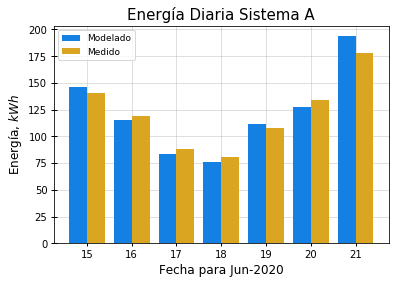

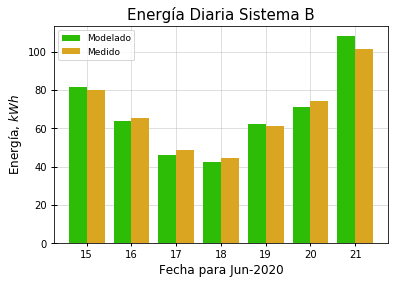

In [39]:
#Energy Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.bar(r1, bar_sim_energy_SysA['Daily Energy, kWh'], width, label='Modelado', color='#1580E4', linewidth=2);
plt.bar(r3, bar_mea_energy_SysA['Energy SysA, kWh'].values, width, label='Medido', color='goldenrod', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Diaria Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Energía, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Val_Daily_Energy_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.bar(r1, bar_sim_energy_SysB['Daily Energy, kWh'], width, label='Modelado', color='#2DBD07', linewidth=2);
plt.bar(r3, bar_mea_energy_SysB['Energy SysB, kWh'], width, label='Medido', color='goldenrod', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Diaria Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Energía, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);
ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO_Val_Daily_Energy_SysB.eps', bbox_inches='tight')

##### 1.10.5. Detailed Daily Energy for PVLIB, PVWatts and PVSyst

In [40]:
bar_width = 0.1;
width = 0.2;

days = np.linspace(int(start.day), int(end.day), int(end.day)-int(start.day)+1)

x = np.arange(len(days))

r1 = np.arange(len(bar_sim_energy_SysB))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]


int_days = []
for day in days:
    int_days.append(int(day))

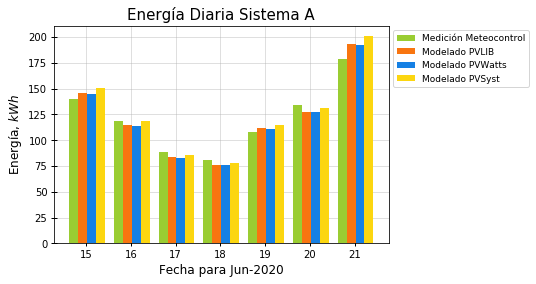

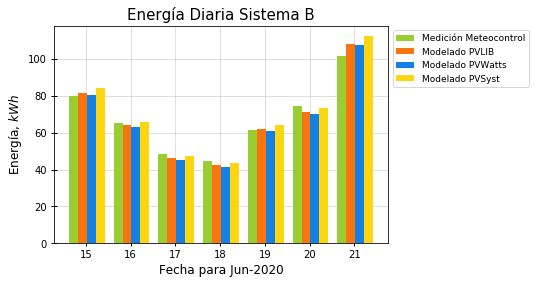

In [41]:
#Energy Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.bar(r1, bar_mea_energy_SysA['Energy SysA, kWh'].values, width, label='Medición Meteocontrol', color='yellowgreen', linewidth=2);
plt.bar(r3, bar_sim_energy_SysA['Daily Energy, kWh'], width, label='Modelado PVLIB', color='#F87510', linewidth=2);
plt.bar(r5, bar_sim_energy_SysA_PVW['Daily Energy, kWh']/kilo, width, label='Modelado PVWatts', color='#1580E4', linewidth=2);
plt.bar(r7, bar_sim_energy_SysA_PVS['Daily Energy, kWh'], width, label='Modelado PVSyst', color='#FCD610', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Diaria Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Energía, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width + width/2.5, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO2_Val_Daily_Energy_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.bar(r1, bar_mea_energy_SysB['Energy SysB, kWh'].values, width, label='Medición Meteocontrol', color='yellowgreen', linewidth=2);
plt.bar(r3, bar_sim_energy_SysB['Daily Energy, kWh'], width, label='Modelado PVLIB', color='#F87510', linewidth=2);
plt.bar(r5, bar_sim_energy_SysB_PVW['Daily Energy, kWh']/kilo, width, label='Modelado PVWatts', color='#1580E4', linewidth=2);
plt.bar(r7, bar_sim_energy_SysB_PVS['Daily Energy, kWh'], width, label='Modelado PVSyst', color='#FCD610', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Diaria Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Energía, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);
ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width + width/2.5, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO2_Val_Daily_Energy_SysB.eps', bbox_inches='tight')

##### 1.10.6. Daily Energy Error

In [42]:
#System A
energyerror_SysA = bar_mea_energy_SysA

energyerror_SysA = energyerror_SysA.rename(columns={'Energy SysA, kWh': 'Mea. Energy SysA, kWh'})

energyerror_SysA['Error PVLIB, %'] = (((bar_mea_energy_SysA['Energy SysA, kWh'] - bar_sim_energy_SysA['Daily Energy, kWh'])/bar_mea_energy_SysA['Energy SysA, kWh'])*100).round(2)
energyerror_SysA['Error PVWatts, %'] = (((bar_mea_energy_SysA['Energy SysA, kWh'] - bar_sim_energy_SysA_PVW['Daily Energy, kWh']/kilo)/bar_mea_energy_SysA['Energy SysA, kWh'])*100).round(2)
energyerror_SysA['Error PVSyst, %'] = (((bar_mea_energy_SysA['Energy SysA, kWh'] - bar_sim_energy_SysA_PVS['Daily Energy, kWh'])/bar_mea_energy_SysA['Energy SysA, kWh'])*100).round(2)

#System B
energyerror_SysB = bar_mea_energy_SysB

energyerror_SysB = energyerror_SysB.rename(columns={'Energy SysB, kWh': 'Mea. Energy SysB, kWh'})

energyerror_SysB['Error PVLIB, %'] = (((bar_mea_energy_SysB['Energy SysB, kWh'] - bar_sim_energy_SysB['Daily Energy, kWh'])/bar_mea_energy_SysB['Energy SysB, kWh'])*100).round(2)
energyerror_SysB['Error PVWatts, %'] = (((bar_mea_energy_SysB['Energy SysB, kWh'] - bar_sim_energy_SysB_PVW['Daily Energy, kWh']/kilo)/bar_mea_energy_SysB['Energy SysB, kWh'])*100).round(2)
energyerror_SysB['Error PVSyst, %'] = (((bar_mea_energy_SysB['Energy SysB, kWh'] - bar_sim_energy_SysB_PVS['Daily Energy, kWh'])/bar_mea_energy_SysB['Energy SysB, kWh'])*100).round(2)

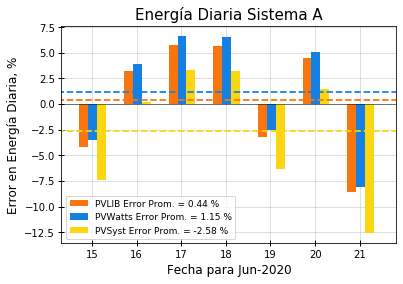

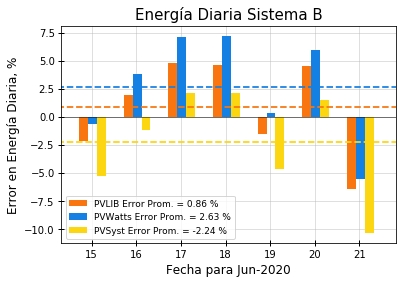

In [43]:
#Energy Error Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

#Mean Error Values
meanerror_PVLIB = round(energyerror_SysA['Error PVLIB, %'].mean(), 2)
meanerror_PVW = round(energyerror_SysA['Error PVWatts, %'].mean(), 2)
meanerror_PVS = round(energyerror_SysA['Error PVSyst, %'].mean(), 2)

plt.bar(r1, energyerror_SysA['Error PVLIB, %'], width, label='PVLIB Error Prom. = ' + f'{meanerror_PVLIB}' + ' %', color='#F87510', linewidth=2);
plt.bar(r3, energyerror_SysA['Error PVWatts, %'], width, label='PVWatts Error Prom. = ' + f'{meanerror_PVW}' + ' %', color='#1580E4', linewidth=2);
plt.bar(r5, energyerror_SysA['Error PVSyst, %'], width, label='PVSyst Error Prom. = ' + f'{meanerror_PVS}' + ' %', color='#FCD610', linewidth=2);

#Horizontal Lines
plt.hlines(y=0, xmin=-1, xmax=x[-1]+1, colors='black', linestyles='solid', label='', linewidth=0.5) #Zero
plt.hlines(y=meanerror_PVLIB, xmin=-1, xmax=x[-1]+1, colors='#F87510', linestyles='--', label='', linewidth=1.75) #PVLIB
plt.hlines(y=meanerror_PVW, xmin=-1, xmax=x[-1]+1, colors='#1580E4', linestyles='--', label='', linewidth=1.75) #PVWatts
plt.hlines(y=meanerror_PVS, xmin=-1, xmax=x[-1]+1, colors='#FCD610', linestyles='--', label='', linewidth=1.75) #PVSyst

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Diaria Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Error en Energía Diaria, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/1.1, int_days)
plt.ylim(None, None)
plt.xlim(-0.5, 7)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO4_Energy_Error_SysA.eps', bbox_inches='tight')


#System B Figure
fig2, ax2 = plt.subplots();

#Mean Error Values
meanerror_PVLIB = round(energyerror_SysB['Error PVLIB, %'].mean(), 2)
meanerror_PVW = round(energyerror_SysB['Error PVWatts, %'].mean(), 2)
meanerror_PVS = round(energyerror_SysB['Error PVSyst, %'].mean(), 2)

plt.bar(r1, energyerror_SysB['Error PVLIB, %'], width, label='PVLIB Error Prom. = ' + f'{meanerror_PVLIB}' + ' %', color='#F87510', linewidth=2);
plt.bar(r3, energyerror_SysB['Error PVWatts, %'], width, label='PVWatts Error Prom. = ' + f'{meanerror_PVW}' + ' %', color='#1580E4', linewidth=2);
plt.bar(r5, energyerror_SysB['Error PVSyst, %'], width, label='PVSyst Error Prom. = ' + f'{meanerror_PVS}' + ' %', color='#FCD610', linewidth=2);

#Horizontal Lines
plt.hlines(y=0, xmin=-1, xmax=x[-1]+1, colors='black', linestyles='solid', label='', linewidth=0.5) #Zero
plt.hlines(y=meanerror_PVLIB, xmin=-1, xmax=x[-1]+1, colors='#F87510', linestyles='--', label='', linewidth=1.75) #PVLIB
plt.hlines(y=meanerror_PVW, xmin=-1, xmax=x[-1]+1, colors='#1580E4', linestyles='--', label='', linewidth=1.75) #PVWatts
plt.hlines(y=meanerror_PVS, xmin=-1, xmax=x[-1]+1, colors='#FCD610', linestyles='--', label='', linewidth=1.75) #PVSyst

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Diaria Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Error en Energía Diaria, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Fecha para {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/1.1, int_days)
plt.ylim(None, None)
plt.xlim(-0.5, 7)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO4_Energy_Error_SysB.eps', bbox_inches='tight')

### 1.11. Irradiance vs. AC Power

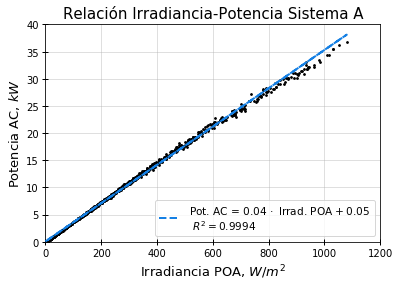

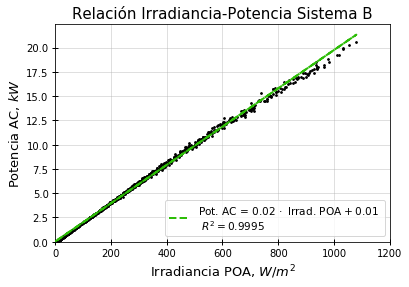

In [44]:
#System A
#Least Squares Linear Regression
x_value = measured_irrad['New Meteo. Irrad., W/m2']
y_value = ACPow_SysA['AC Power']

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 1200

#x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Pot. AC = " + f"{slope_SysA.round(2)} $· \:$ Irrad. POA $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_irrad['New Meteo. Irrad., W/m2'], ACPow_SysA['AC Power'], color='black', marker='o', s=3)

y = x
#plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Relación Irradiancia-Potencia Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Potencia AC, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Irradiancia POA, $W/m^2$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, None);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO6_IrradPot_SysA_Semana.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_irrad['New Meteo. Irrad., W/m2']
y_value = ACPow_SysB['AC Power']

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 1200

#x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Pot. AC = " + f"{slope_SysB.round(2)} $· \:$ Irrad. POA $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_irrad['New Meteo. Irrad., W/m2'], ACPow_SysB['AC Power'], color='black', marker='o', s=3)

y = x
#plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Relación Irradiancia-Potencia Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Potencia AC, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Irradiancia POA, $W/m^2$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, None);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO6_IrradPot_SysB_Semana.eps', bbox_inches='tight')

___
# SECTION 2: Year Information

In [45]:
file_name = '/Users/nelsonsasa07/Documents/PV Simulations/CNO/CNO_Data.xlsx'

#Meteocontrol Irradiance Measurement
irrad_sheet = 'Radiacin_2020'
measured_irrad = pd.read_excel(io=file_name, sheet_name=irrad_sheet)
measured_irrad = pd.DataFrame(measured_irrad)

#Meteocontrol DC Voltage Measurement
dcvoltage_sheet = 'Tensin_DC_2020'
measured_dcvoltage = pd.read_excel(io=file_name, sheet_name=dcvoltage_sheet)
measured_dcvoltage = pd.DataFrame(measured_dcvoltage)

#Meteocontrol DC Current Measurement
dccurrent_sheet = 'Corriente_DC_2020'
measured_dccurrent = pd.read_excel(io=file_name, sheet_name=dccurrent_sheet)
measured_dccurrent = pd.DataFrame(measured_dccurrent)

#Meteocontrol DC Power Measurement
dcpower_sheet = 'Potencia_DC_2020'
measured_dcpower = pd.read_excel(io=file_name, sheet_name=dcpower_sheet)
measured_dcpower = pd.DataFrame(measured_dcpower)

#Meteocontrol AC Power Measurement
acpower_sheet = 'Potencia_AC_2020'
measured_acpower = pd.read_excel(io=file_name, sheet_name=acpower_sheet)
measured_acpower = pd.DataFrame(measured_acpower)

#Meteocontrol Module Temperature Measurement
modtemp_sheet = 'Temperatura-Energa_2020'
measured_modtemp = pd.read_excel(io=file_name, sheet_name=modtemp_sheet)
measured_modtemp = pd.DataFrame(measured_modtemp)

#Meteocontrol Energy Measurement
energy_sheet = 'Energa_2020'
measured_energy = pd.read_excel(io=file_name, sheet_name=energy_sheet)
measured_energy = pd.DataFrame(measured_energy)

In [46]:
new_irrad = []
for data in measured_irrad['Meteocontrol Irrad., W/m2']:
    if data <= 2:
        new_irrad.append(0)
    else:
        new_irrad.append(data)

new_irrad = pd.DataFrame(new_irrad)

new_irrad = new_irrad.set_index(measured_irrad.index)

measured_irrad['New Meteo. Irrad., W/m2'] = new_irrad

In [47]:
measured_acpower = measured_acpower.set_index(measured_acpower['Date'])
measured_energy = measured_energy.set_index(measured_energy['Date'])

### 2.1. PVLIB Model Initialization

In [48]:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_cec(measured_irrad['New Meteo. Irrad., W/m2'],
                                                     measured_modtemp['Modules Temp., °C'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     Adjust=9.380614,
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info = pvsystem.singlediode(photocurrent=IL,
                                  saturation_current=I0,
                                  resistance_series=Rs,
                                  resistance_shunt=Rsh,
                                  nNsVth=nNsVth,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# Scalating CEC et. al. Single Diode Results
data_i_sc = pd.Series(curve_info['i_sc'])
data_v_oc = pd.Series(curve_info['v_oc'])
data_i_mp = pd.Series(curve_info['i_mp'])
data_v_mp = pd.Series(curve_info['v_mp'])
data_p_mp = pd.Series(curve_info['p_mp'])
data_i_x = pd.Series(curve_info['i_x'])
data_i_xx = pd.Series(curve_info['i_xx'])

results_general = pd.DataFrame({'i_sc': data_i_sc, 
                        'v_oc': data_v_oc,
                        'i_mp': data_i_mp, 
                        'v_mp': data_v_mp, 
                        'p_mp': data_p_mp, 
                        'i_x': data_i_x,
                        'i_xx': data_i_xx})

datetime_index = measured_irrad['Date']

sc_SysA = system_A.scale_voltage_current_power(results_general)
#sc_SysA['Datetime'] = pd.to_datetime(datetime_index)
sc_SysA = sc_SysA.set_index(datetime_index)

sc_SysB = system_B.scale_voltage_current_power(results_general)
#sc_SysB['Datetime'] = pd.to_datetime(datetime_index)
sc_SysB = sc_SysB.set_index(datetime_index)

In [49]:
#Setting Datetime-Index for Measured Irrad.
measured_irrad['Datetime'] = pd.to_datetime(datetime_index)
measured_irrad = measured_irrad.set_index('Datetime')

#Setting Datetime-Index for Measured Modules Temp.
measured_modtemp['Datetime'] = pd.to_datetime(datetime_index)
measured_modtemp = measured_modtemp.set_index('Datetime')

In [50]:
months = np.linspace(1, int(end.month), int(end.month))

In [51]:
losses_pvw = pvsystem.pvwatts_losses(soiling=2, shading=3, snow=0, mismatch=2, wiring=2, 
                                       connections=0.5, lid=1.5, nameplate_rating=1, age=0, 
                                       availability=3)

#SystemA
losses_SysA = np.linspace(11.23, 26.9, len(months)) 
losses_SysA = losses_SysA/100

loss_jan = np.array(np.repeat(losses_SysA[0], 743))
loss_feb = np.array(np.repeat(losses_SysA[1], 696))
loss_mar = np.array(np.repeat(losses_SysA[2], 744))
loss_abr = np.array(np.repeat(losses_SysA[3], 720))
loss_may = np.array(np.repeat(losses_SysA[4], 744))
loss_jun = np.array(np.repeat(losses_SysA[5], 552))

datalosses_SysA = np.concatenate([loss_jan, loss_feb, loss_mar, loss_abr, loss_may, loss_jun])

losses_SysA_PVW = np.linspace(11.23, 25.5, len(months))
losses_SysA_PVW = losses_SysA_PVW/100

loss_jan = np.array(np.repeat(losses_SysA_PVW[0], 743))
loss_feb = np.array(np.repeat(losses_SysA_PVW[1], 696))
loss_mar = np.array(np.repeat(losses_SysA_PVW[2], 744))
loss_abr = np.array(np.repeat(losses_SysA_PVW[3], 720))
loss_may = np.array(np.repeat(losses_SysA_PVW[4], 744))
loss_jun = np.array(np.repeat(losses_SysA_PVW[5], 552))

datalosses_SysA_PVW = np.concatenate([loss_jan, loss_feb, loss_mar, loss_abr, loss_may, loss_jun])

#SystemB
losses_SysB = np.linspace(0, 26.9, len(months)-1)
losses_SysB = np.insert(losses_SysB, 0, 0)
losses_SysB = losses_SysB/100

loss_jan = np.array(np.repeat(losses_SysB[0], 743))
loss_feb = np.array(np.repeat(losses_SysB[1], 696))
loss_mar = np.array(np.repeat(losses_SysB[2], 744))
loss_abr = np.array(np.repeat(losses_SysB[3], 720))
loss_may = np.array(np.repeat(losses_SysB[4], 744))
loss_jun = np.array(np.repeat(losses_SysB[5], 552))

datalosses_SysB = np.concatenate([loss_jan, loss_feb, loss_mar, loss_abr, loss_may, loss_jun])

losses_SysB_PVW = np.linspace(0, 25.5, len(months)-1)
losses_SysB_PVW = np.insert(losses_SysB_PVW, 0, 0)
losses_SysB_PVW = losses_SysB_PVW/100

loss_jan = np.array(np.repeat(losses_SysB_PVW[0], 743))
loss_feb = np.array(np.repeat(losses_SysB_PVW[1], 696))
loss_mar = np.array(np.repeat(losses_SysB_PVW[2], 744))
loss_abr = np.array(np.repeat(losses_SysB_PVW[3], 720))
loss_may = np.array(np.repeat(losses_SysB_PVW[4], 744))
loss_jun = np.array(np.repeat(losses_SysB_PVW[5], 552))

datalosses_SysB_PVW = np.concatenate([loss_jan, loss_feb, loss_mar, loss_abr, loss_may, loss_jun])

#Losses System A
sc_SysA['i_mp'] = sc_SysA['i_mp'] - sc_SysA['i_mp']*datalosses_SysA
sc_SysA['p_mp'] = sc_SysA['p_mp'] - sc_SysA['p_mp']*datalosses_SysA

#Losses System B
sc_SysB['i_mp'] = sc_SysB['i_mp'] - sc_SysB['i_mp']*datalosses_SysB
sc_SysB['p_mp'] = sc_SysB['p_mp'] - sc_SysB['p_mp']*datalosses_SysB

___
````python
x1 = [1,2,3,4]
x2 = np.insert(x1, 0, np.repeat(x1[0],3))
````
___

### 2.2. PVWatts DC Model Initialization

In [52]:
#Variables Required for PVWatts_DC Function
eta_inv_nom = 0.98184; #CEC Weighted Efficiency, Value from PVWatts API
eta_inv_ref=0.986; #Value from PVWatts API
pdc0_inv = 50881.8; #Value from PVWatts API

#PVWatts DC Model
pvwatts_dc_model = pvsystem.pvwatts_dc(measured_irrad['New Meteo. Irrad., W/m2'], 
                                       measured_modtemp['Modules Temp., °C'], 
                                       pdc0=module['pdc0'], 
                                       gamma_pdc=module['gamma_pdc'], 
                                       temp_ref=25.0)

#Scalating PVWatts DC Model Results
pvwatts_dc_model_SysA = pvwatts_dc_model*mps_SysA*spi_SysA; #Scalated DC Power for SysA
pvwatts_dc_model_SysB = pvwatts_dc_model*mps_SysB*spi_SysB; #Scalated DC Power for SysB

#Decrease Due to Losses
pvwatts_dc_model_SysA = pvwatts_dc_model_SysA - (pvwatts_dc_model_SysA*datalosses_SysA_PVW); #DC Power for SysA with Losses
pvwatts_dc_model_SysB = pvwatts_dc_model_SysB - (pvwatts_dc_model_SysB*datalosses_SysB_PVW); #DC Power for SysA with Losses

### 2.3. PVSyst DC Model Initialization

In [53]:
IL_PVS, I0_PVS, Rs_PVS, Rsh_PVS, nNsVth_PVS = pvsystem.calcparams_pvsyst(measured_irrad['New Meteo. Irrad., W/m2'],
                                                     measured_modtemp['Modules Temp., °C'],
                                                     module['alpha_sc'],
                                                     module['gamma_ref'], #Diode Quality Factor, Value from PVSyst
                                                     module['mu_gamma'], #PVSyst specify that mono-cSi modules mu_gamma is very close to zero
                                                     I_L_ref=module['I_L_ref'],
                                                     I_o_ref=module['I_o_ref'],
                                                     R_sh_ref=module['R_sh_ref'],
                                                     R_sh_0=module['R_sh_0'], #Resistance shunt at 0 irrad., Value from PVSyst
                                                     R_s=module['R_s'],
                                                     cells_in_series=module['N_s'],
                                                     R_sh_exp=module['R_sh_exp'],
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     irrad_ref=1000, #Retrieved from last link at above description
                                                     temp_ref=25) #Retrieved from last link at above description

curve_info_PVS = pvsystem.singlediode(photocurrent=IL_PVS,
                                  saturation_current=I0_PVS,
                                  resistance_series=Rs_PVS,
                                  resistance_shunt=Rsh_PVS,
                                  nNsVth=nNsVth_PVS,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# Scalating PVSyst Single Diode Results
data_i_sc_PVS = pd.Series(curve_info_PVS['i_sc'])
data_v_oc_PVS = pd.Series(curve_info_PVS['v_oc'])
data_i_mp_PVS = pd.Series(curve_info_PVS['i_mp'])
data_v_mp_PVS = pd.Series(curve_info_PVS['v_mp'])
data_p_mp_PVS = pd.Series(curve_info_PVS['p_mp'])
data_i_x_PVS = pd.Series(curve_info_PVS['i_x'])
data_i_xx_PVS = pd.Series(curve_info_PVS['i_xx'])

results_general_PVS = pd.DataFrame({'i_sc': data_i_sc_PVS, 
                        'v_oc': data_v_oc_PVS,
                        'i_mp': data_i_mp_PVS, 
                        'v_mp': data_v_mp_PVS, 
                        'p_mp': data_p_mp_PVS, 
                        'i_x': data_i_x_PVS,
                        'i_xx': data_i_xx_PVS})

datetime_index = measured_irrad['Date']

sc_SysA_PVS = system_A.scale_voltage_current_power(results_general_PVS)
#sc_SysA_PVS['Datetime'] = pd.to_datetime(datetime_index)
sc_SysA_PVS = sc_SysA_PVS.set_index(datetime_index)

sc_SysB_PVS = system_B.scale_voltage_current_power(results_general_PVS)
#sc_SysB_PVS['Datetime'] = pd.to_datetime(datetime_index)
sc_SysB_PVS = sc_SysB_PVS.set_index(datetime_index)

In [54]:
#Losses System A
sc_SysA_PVS['i_mp'] = sc_SysA_PVS['i_mp'] - sc_SysA_PVS['i_mp']*datalosses_SysA
sc_SysA_PVS['p_mp'] = sc_SysA_PVS['p_mp'] - sc_SysA_PVS['p_mp']*datalosses_SysA

#Losses System B
sc_SysB_PVS['i_mp'] = sc_SysB_PVS['i_mp'] - sc_SysB_PVS['i_mp']*datalosses_SysB
sc_SysB_PVS['p_mp'] = sc_SysB_PVS['p_mp'] - sc_SysB_PVS['p_mp']*datalosses_SysB

### 2.3. AC Power

In [55]:
#PVLIB Voltage Losses
sc_SysA['v_mp'] = sc_SysA['v_mp'] - sc_SysA['v_mp']*datalosses_SysA
sc_SysB['v_mp'] = sc_SysB['v_mp'] - sc_SysB['v_mp']*datalosses_SysB

#PVLIB AC Model
ACPow_SysA = pvsystem.snlinverter(sc_SysA['v_mp'], sc_SysA['p_mp'], inverter_A)/kilo;
ACPow_SysB = pvsystem.snlinverter(sc_SysB['v_mp'], sc_SysB['p_mp'], inverter_B)/kilo;

#PVWatts AC Model
pvwatts_ac_model_SysA = pvsystem.pvwatts_ac(pdc=pvwatts_dc_model_SysA,
                                       pdc0=pdc0_inv, 
                                       eta_inv_nom=eta_inv_nom, 
                                       eta_inv_ref=eta_inv_ref)

pvwatts_ac_model_SysB = pvsystem.pvwatts_ac(pdc=pvwatts_dc_model_SysB,
                                       pdc0=pdc0_inv, 
                                       eta_inv_nom=eta_inv_nom, 
                                       eta_inv_ref=eta_inv_ref)

#Changing NaN Values from Both Arrays to Zero (To Avoid Setbacks)
pvwatts_ac_model_SysA = pvwatts_ac_model_SysA.fillna(0);
pvwatts_ac_model_SysB = pvwatts_ac_model_SysB.fillna(0);

#PVSyst Voltage Losses
sc_SysA_PVS['v_mp'] = sc_SysA_PVS['v_mp'] - sc_SysA_PVS['v_mp']*losses
sc_SysB_PVS['v_mp'] = sc_SysB_PVS['v_mp'] - sc_SysB_PVS['v_mp']*losses

#PVSyst AC Model
ACPow_SysA_PVS = pvsystem.snlinverter(sc_SysA_PVS['v_mp'], sc_SysA_PVS['p_mp'], inverter_A)/kilo;
ACPow_SysB_PVS = pvsystem.snlinverter(sc_SysB_PVS['v_mp'], sc_SysB_PVS['p_mp'], inverter_B)/kilo;

##### 2.3.1. Monthly AC Power

In [56]:
#System A
PVL_month_ACPower_SysA = ACPow_SysA.resample('1m').sum();

PVW_month_ACPower_SysA = pvwatts_ac_model_SysA.resample('1m').sum();
PVW_month_ACPower_SysA = PVW_month_ACPower_SysA/kilo;

PVS_month_ACPower_SysA = ACPow_SysA_PVS.resample('1m').sum();

measured_month_ACPower_SysA = measured_acpower['AC Power SysA, W'].resample('1m').sum();
measured_month_ACPower_SysA = measured_month_ACPower_SysA/kilo;

#System B
PVL_month_ACPower_SysB = ACPow_SysB.resample('1m').sum();

PVW_month_ACPower_SysB = pvwatts_ac_model_SysB.resample('1m').sum();
PVW_month_ACPower_SysB = PVW_month_ACPower_SysB/kilo;

PVS_month_ACPower_SysB = ACPow_SysB_PVS.resample('1m').sum();

measured_month_ACPower_SysB = measured_acpower['AC Power SysB, W'].resample('1m').sum();
measured_month_ACPower_SysB = measured_month_ACPower_SysB/kilo;

In [57]:
bar_width = 0.1;
width = 0.2;

r1 = np.arange(len(months))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

int_months = ['Ene.', 'Feb.', 'Mar.', 'Abr.', 'May.', 'Jun.']
#for month in months:
#    int_months.append(int(month))

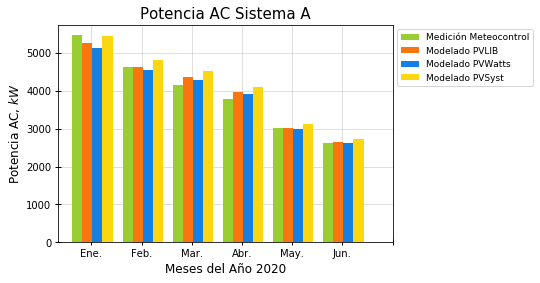

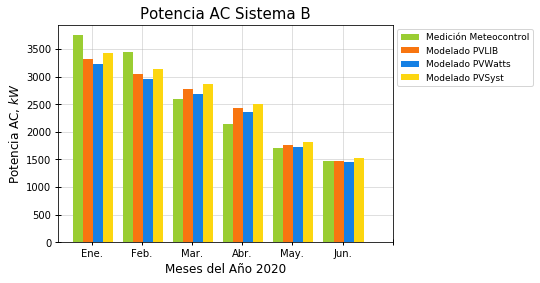

In [58]:
#Monthly AC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.bar(r1, measured_month_ACPower_SysA, width, label='Medición Meteocontrol', color='yellowgreen', linewidth=2);
plt.bar(r3, PVL_month_ACPower_SysA, width, label='Modelado PVLIB', color='#F87510', linewidth=2);
plt.bar(r5, PVW_month_ACPower_SysA, width, label='Modelado PVWatts', color='#1580E4', linewidth=2);
plt.bar(r7, PVS_month_ACPower_SysA, width, label='Modelado PVSyst', color='#FCD610', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Potencia AC Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Potencia AC, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Meses del Año {}'.format(start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width + width/2.5, int_months)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO3_Val_ACPower_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.bar(r1, measured_month_ACPower_SysB, width, label='Medición Meteocontrol', color='yellowgreen', linewidth=2);
plt.bar(r3, PVL_month_ACPower_SysB, width, label='Modelado PVLIB', color='#F87510', linewidth=2);
plt.bar(r5, PVW_month_ACPower_SysB, width, label='Modelado PVWatts', color='#1580E4', linewidth=2);
plt.bar(r7, PVS_month_ACPower_SysB, width, label='Modelado PVSyst', color='#FCD610', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Potencia AC Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Potencia AC, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Meses del Año {}'.format(start.year), fontname="Helvetica", fontsize=12);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width + width/2.5, int_months)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO3_Val_ACPower_SysB.eps', bbox_inches='tight')

### 2.4. Monthly Energy

##### 2.4.1. PVLIB

In [59]:
#SystemA
ACPow_SysA = pd.DataFrame(ACPow_SysA)
ACPow_SysA['Day'] = ACPow_SysA.index.day
ACPow_SysA['AC Power'] = ACPow_SysA[0]
del ACPow_SysA[0]

fix_ACPow_SysA = []
for data in ACPow_SysA['AC Power']:
    if data < 0:
        fix_ACPow_SysA.append(0)
    else:
        fix_ACPow_SysA.append(data)

del ACPow_SysA['AC Power']
ACPow_SysA['AC Power'] = fix_ACPow_SysA

#System B
ACPow_SysB = pd.DataFrame(ACPow_SysB)
ACPow_SysB['Day'] = ACPow_SysB.index.day
ACPow_SysB['AC Power'] = ACPow_SysB[0]
del ACPow_SysB[0]

fix_ACPow_SysB = []
for data in ACPow_SysB['AC Power']:
    if data < 0:
        fix_ACPow_SysB.append(0)
    else:
        fix_ACPow_SysB.append(data)

del ACPow_SysB['AC Power']
ACPow_SysB['AC Power'] = fix_ACPow_SysB

index = np.linspace(1, len(ACPow_SysA['Day']), len(ACPow_SysA['Day'])).round(0)
index = index - 1
ACPow_SysA['Index'] = index
ACPow_SysB['Index'] = index

min_to_hour = 60/60 #60 minutes equivalent to hour
ACPow_SysA['Energy'] = ACPow_SysA['AC Power']*min_to_hour
ACPow_SysB['Energy'] = ACPow_SysB['AC Power']*min_to_hour

In [60]:
#Daily Energy System A
daily_energy_SysA = []
for index in ACPow_SysA['Index']:
    new_day = ACPow_SysA.index[int(index)].day - ACPow_SysA.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA.append(0)
    else:
        value = ACPow_SysA['Energy'][int(index)] + daily_energy_SysA[int(index)-1]
        daily_energy_SysA.append(value)
        
daily_energy_SysA = pd.DataFrame(daily_energy_SysA)
daily_energy_SysA = daily_energy_SysA.set_index(ACPow_SysA.index)

daily_energy_SysA['Daily Energy, kWh'] = daily_energy_SysA[0]
del daily_energy_SysA[0]

#Daily Energy System B
daily_energy_SysB = []
for index in ACPow_SysB['Index']:
    new_day = ACPow_SysB.index[int(index)].day - ACPow_SysB.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB.append(0)
    else:
        value = ACPow_SysB['Energy'][int(index)] + daily_energy_SysB[int(index)-1]
        daily_energy_SysB.append(value)
        
daily_energy_SysB = pd.DataFrame(daily_energy_SysB)
daily_energy_SysB = daily_energy_SysB.set_index(ACPow_SysB.index)
daily_energy_SysB
daily_energy_SysB['Daily Energy, kWh'] = daily_energy_SysB[0]
del daily_energy_SysB[0]

In [61]:
#Resampling Measured Daily Energy
#System A
bar_mea_energy_SysA = pd.DataFrame(measured_energy['Energy SysA, kWh'])
bar_mea_energy_SysA = bar_mea_energy_SysA.set_index(daily_energy_SysA.index)

bar_mea_energy_SysA = bar_mea_energy_SysA.resample('1d').max();
month_bar_mea_energy_SysA = bar_mea_energy_SysA.resample('1m').sum();

#System B
bar_mea_energy_SysB = pd.DataFrame(measured_energy['Energy SysB, kWh'])
bar_mea_energy_SysB = bar_mea_energy_SysB.set_index(daily_energy_SysB.index)

bar_mea_energy_SysB = bar_mea_energy_SysB.resample('1d').max();
month_bar_mea_energy_SysB = bar_mea_energy_SysB.resample('1m').sum();

#Resampling Simulated Daily Energy
#System A
bar_sim_energy_SysA = pd.DataFrame(daily_energy_SysA['Daily Energy, kWh'])
bar_sim_energy_SysA = bar_sim_energy_SysA.set_index(daily_energy_SysA.index)

bar_sim_energy_SysA = bar_sim_energy_SysA.resample('1d').max();
month_bar_sim_energy_SysA = bar_sim_energy_SysA.resample('1m').sum();

#System B
bar_sim_energy_SysB = pd.DataFrame(daily_energy_SysB['Daily Energy, kWh'])
bar_sim_energy_SysB = bar_sim_energy_SysB.set_index(daily_energy_SysB.index)

bar_sim_energy_SysB = bar_sim_energy_SysB.resample('1d').max();
month_bar_sim_energy_SysB = bar_sim_energy_SysB.resample('1m').sum();

##### 2.4.2. PVWatts

In [62]:
#SystemA
ACPow_SysA_PVW = pd.DataFrame(pvwatts_ac_model_SysA)
ACPow_SysA_PVW['Day'] = ACPow_SysA_PVW.index.day
ACPow_SysA_PVW['AC Power'] = ACPow_SysA_PVW[0]
del ACPow_SysA_PVW[0]

fix_ACPow_SysA_PVW = []
for data in ACPow_SysA_PVW['AC Power']:
    if data < 0:
        fix_ACPow_SysA_PVW.append(0)
    else:
        fix_ACPow_SysA_PVW.append(data)

del ACPow_SysA_PVW['AC Power']
ACPow_SysA_PVW['AC Power'] = fix_ACPow_SysA_PVW

#System B
ACPow_SysB_PVW = pd.DataFrame(pvwatts_ac_model_SysB)
ACPow_SysB_PVW['Day'] = ACPow_SysB_PVW.index.day
ACPow_SysB_PVW['AC Power'] = ACPow_SysB_PVW[0]
del ACPow_SysB_PVW[0]

fix_ACPow_SysB_PVW = []
for data in ACPow_SysB_PVW['AC Power']:
    if data < 0:
        fix_ACPow_SysB_PVW.append(0)
    else:
        fix_ACPow_SysB_PVW.append(data)

del ACPow_SysB_PVW['AC Power']
ACPow_SysB_PVW['AC Power'] = fix_ACPow_SysB_PVW

index = np.linspace(1, len(ACPow_SysA_PVW['Day']), len(ACPow_SysA_PVW['Day'])).round(0)
index = index - 1
ACPow_SysA_PVW['Index'] = index
ACPow_SysB_PVW['Index'] = index

min_to_hour = 60/60 #60 minutes equivalent to hour
ACPow_SysA_PVW['Energy'] = ACPow_SysA_PVW['AC Power']*min_to_hour
ACPow_SysB_PVW['Energy'] = ACPow_SysB_PVW['AC Power']*min_to_hour

In [63]:
#Daily Energy System A
daily_energy_SysA_PVW = []
for index in ACPow_SysA_PVW['Index']:
    new_day = ACPow_SysA_PVW.index[int(index)].day - ACPow_SysA_PVW.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA_PVW.append(0)
    else:
        value = ACPow_SysA_PVW['Energy'][int(index)] + daily_energy_SysA_PVW[int(index)-1]
        daily_energy_SysA_PVW.append(value)
        
daily_energy_SysA_PVW = pd.DataFrame(daily_energy_SysA_PVW)
daily_energy_SysA_PVW = daily_energy_SysA_PVW.set_index(ACPow_SysA_PVW.index)
daily_energy_SysA_PVW
daily_energy_SysA_PVW['Daily Energy, kWh'] = daily_energy_SysA_PVW[0]
del daily_energy_SysA_PVW[0]

#Daily Energy System B
daily_energy_SysB_PVW = []
for index in ACPow_SysB_PVW['Index']:
    new_day = ACPow_SysB_PVW.index[int(index)].day - ACPow_SysB_PVW.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB_PVW.append(0)
    else:
        value = ACPow_SysB_PVW['Energy'][int(index)] + daily_energy_SysB_PVW[int(index)-1]
        daily_energy_SysB_PVW.append(value)
        
daily_energy_SysB_PVW = pd.DataFrame(daily_energy_SysB_PVW)
daily_energy_SysB_PVW = daily_energy_SysB_PVW.set_index(ACPow_SysB_PVW.index)
daily_energy_SysB_PVW
daily_energy_SysB_PVW['Daily Energy, kWh'] = daily_energy_SysB_PVW[0]
del daily_energy_SysB_PVW[0]

In [64]:
#Resampling Simulated Daily Energy
#System A
bar_sim_energy_SysA_PVW = pd.DataFrame(daily_energy_SysA_PVW['Daily Energy, kWh'])
bar_sim_energy_SysA_PVW = bar_sim_energy_SysA_PVW.set_index(daily_energy_SysA_PVW.index)

bar_sim_energy_SysA_PVW = bar_sim_energy_SysA_PVW.resample('1d').max();
month_bar_sim_energy_SysA_PVW = bar_sim_energy_SysA_PVW.resample('1m').sum();

#System B
bar_sim_energy_SysB_PVW = pd.DataFrame(daily_energy_SysB_PVW['Daily Energy, kWh'])
bar_sim_energy_SysB_PVW = bar_sim_energy_SysB_PVW.set_index(daily_energy_SysB_PVW.index)

bar_sim_energy_SysB_PVW = bar_sim_energy_SysB_PVW.resample('1d').max();
month_bar_sim_energy_SysB_PVW = bar_sim_energy_SysB_PVW.resample('1m').sum();

##### 2.4.3. PVSyst

In [65]:
#SystemA
ACPow_SysA_PVS = pd.DataFrame(ACPow_SysA_PVS)
ACPow_SysA_PVS['Day'] = ACPow_SysA_PVS.index.day
ACPow_SysA_PVS['AC Power'] = ACPow_SysA_PVS[0]
del ACPow_SysA_PVS[0]

fix_ACPow_SysA_PVS = []
for data in ACPow_SysA_PVS['AC Power']:
    if data < 0:
        fix_ACPow_SysA_PVS.append(0)
    else:
        fix_ACPow_SysA_PVS.append(data)

del ACPow_SysA_PVS['AC Power']
ACPow_SysA_PVS['AC Power'] = fix_ACPow_SysA_PVS

#System B
ACPow_SysB_PVS = pd.DataFrame(ACPow_SysB_PVS)
ACPow_SysB_PVS['Day'] = ACPow_SysB_PVS.index.day
ACPow_SysB_PVS['AC Power'] = ACPow_SysB_PVS[0]
del ACPow_SysB_PVS[0]

fix_ACPow_SysB_PVS = []
for data in ACPow_SysB_PVS['AC Power']:
    if data < 0:
        fix_ACPow_SysB_PVS.append(0)
    else:
        fix_ACPow_SysB_PVS.append(data)

del ACPow_SysB_PVS['AC Power']
ACPow_SysB_PVS['AC Power'] = fix_ACPow_SysB_PVS

index = np.linspace(1, len(ACPow_SysA_PVS['Day']), len(ACPow_SysA_PVS['Day'])).round(0)
index = index - 1
ACPow_SysA_PVS['Index'] = index
ACPow_SysB_PVS['Index'] = index

min_to_hour = 60/60 #60 minutes equivalent to hour
ACPow_SysA_PVS['Energy'] = ACPow_SysA_PVS['AC Power']*min_to_hour
ACPow_SysB_PVS['Energy'] = ACPow_SysB_PVS['AC Power']*min_to_hour

In [66]:
#Daily Energy System A
daily_energy_SysA_PVS = []
for index in ACPow_SysA_PVS['Index']:
    new_day = ACPow_SysA_PVS.index[int(index)].day - ACPow_SysA_PVS.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA_PVS.append(0)
    else:
        value = ACPow_SysA_PVS['Energy'][int(index)] + daily_energy_SysA_PVS[int(index)-1]
        daily_energy_SysA_PVS.append(value)
        
daily_energy_SysA_PVS = pd.DataFrame(daily_energy_SysA_PVS)
daily_energy_SysA_PVS = daily_energy_SysA_PVS.set_index(ACPow_SysA_PVS.index)
daily_energy_SysA_PVS
daily_energy_SysA_PVS['Daily Energy, kWh'] = daily_energy_SysA_PVS[0]
del daily_energy_SysA_PVS[0]

#Daily Energy System B
daily_energy_SysB_PVS = []
for index in ACPow_SysB_PVS['Index']:
    new_day = ACPow_SysB_PVS.index[int(index)].day - ACPow_SysB_PVS.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB_PVS.append(0)
    else:
        value = ACPow_SysB_PVS['Energy'][int(index)] + daily_energy_SysB_PVS[int(index)-1]
        daily_energy_SysB_PVS.append(value)
        
daily_energy_SysB_PVS = pd.DataFrame(daily_energy_SysB_PVS)
daily_energy_SysB_PVS = daily_energy_SysB_PVS.set_index(ACPow_SysB_PVS.index)
daily_energy_SysB_PVS
daily_energy_SysB_PVS['Daily Energy, kWh'] = daily_energy_SysB_PVS[0]
del daily_energy_SysB_PVS[0]

In [67]:
#Resampling Simulated Daily Energy
#System A
bar_sim_energy_SysA_PVS = pd.DataFrame(daily_energy_SysA_PVS['Daily Energy, kWh'])
bar_sim_energy_SysA_PVS = bar_sim_energy_SysA_PVS.set_index(daily_energy_SysA_PVS.index)

bar_sim_energy_SysA_PVS = bar_sim_energy_SysA_PVS.resample('1d').max();
month_bar_sim_energy_SysA_PVS = bar_sim_energy_SysA_PVS.resample('1m').sum();

#System B
bar_sim_energy_SysB_PVS = pd.DataFrame(daily_energy_SysB_PVS['Daily Energy, kWh'])
bar_sim_energy_SysB_PVS = bar_sim_energy_SysB_PVS.set_index(daily_energy_SysB_PVS.index)

bar_sim_energy_SysB_PVS = bar_sim_energy_SysB_PVS.resample('1d').max();
month_bar_sim_energy_SysB_PVS = bar_sim_energy_SysB_PVS.resample('1m').sum();

##### 2.4.4. Monthly Energy Plot

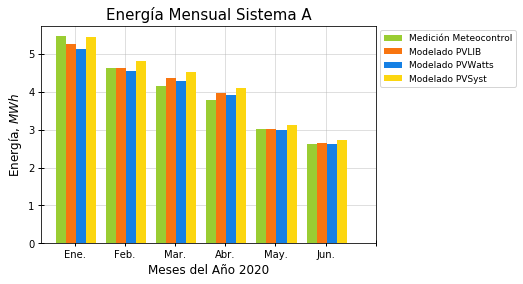

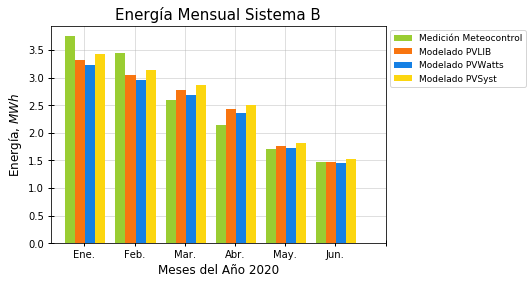

In [68]:
#Energy Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.bar(r1, month_bar_mea_energy_SysA['Energy SysA, kWh']/kilo, width, label='Medición Meteocontrol', color='yellowgreen', linewidth=2);
plt.bar(r3, month_bar_sim_energy_SysA['Daily Energy, kWh']/kilo, width, label='Modelado PVLIB', color='#F87510', linewidth=2);
plt.bar(r5, month_bar_sim_energy_SysA_PVW['Daily Energy, kWh']/(kilo*kilo), width, label='Modelado PVWatts', color='#1580E4', linewidth=2);
plt.bar(r7, month_bar_sim_energy_SysA_PVS['Daily Energy, kWh']/kilo, width, label='Modelado PVSyst', color='#FCD610', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Mensual Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Energía, $MWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Meses del Año {}'.format(start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width + width/2.5, int_months)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO5_Val_Monthly_Energy_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.bar(r1, month_bar_mea_energy_SysB['Energy SysB, kWh']/kilo, width, label='Medición Meteocontrol', color='yellowgreen', linewidth=2);
plt.bar(r3, month_bar_sim_energy_SysB['Daily Energy, kWh']/kilo, width, label='Modelado PVLIB', color='#F87510', linewidth=2);
plt.bar(r5, month_bar_sim_energy_SysB_PVW['Daily Energy, kWh']/(kilo*kilo), width, label='Modelado PVWatts', color='#1580E4', linewidth=2);
plt.bar(r7, month_bar_sim_energy_SysB_PVS['Daily Energy, kWh']/kilo, width, label='Modelado PVSyst', color='#FCD610', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Mensual Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Energía, $MWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Meses del Año {}'.format(start.year), fontname="Helvetica", fontsize=12);
ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width + width/2.5, int_months)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO5_Val_Monthly_Energy_SysB.eps', bbox_inches='tight')

##### 2.4.5. Monthly Energy Percentage Error

In [69]:
#System A
#Monthly Energy
mea_monthly_energy = month_bar_mea_energy_SysA/kilo
PVL_monthly_energy = month_bar_sim_energy_SysA/kilo
PVW_monthly_energy = month_bar_sim_energy_SysA_PVW/(kilo*kilo)
PVS_monthly_energy = month_bar_sim_energy_SysA_PVS/kilo

#Percentage Error
energyerror_SysA = []
energyerror_SysA = round(mea_monthly_energy, 2)

energyerror_SysA = energyerror_SysA.rename(columns={'Energy SysA, kWh': 'Mea. Energy SysA, MWh'})

energyerror_SysA['Error PVLIB, %'] = (((energyerror_SysA['Mea. Energy SysA, MWh'] - PVL_monthly_energy['Daily Energy, kWh'])/energyerror_SysA['Mea. Energy SysA, MWh'])*100).round(2)
energyerror_SysA['Error PVWatts, %'] = (((energyerror_SysA['Mea. Energy SysA, MWh'] - PVW_monthly_energy['Daily Energy, kWh'])/energyerror_SysA['Mea. Energy SysA, MWh'])*100).round(2)
energyerror_SysA['Error PVSyst, %'] = (((energyerror_SysA['Mea. Energy SysA, MWh'] - PVS_monthly_energy['Daily Energy, kWh'])/energyerror_SysA['Mea. Energy SysA, MWh'])*100).round(2)

#System B
#Monthly Energy
mea_monthly_energy = month_bar_mea_energy_SysB/kilo
PVL_monthly_energy = month_bar_sim_energy_SysB/kilo
PVW_monthly_energy = month_bar_sim_energy_SysB_PVW/(kilo*kilo)
PVS_monthly_energy = month_bar_sim_energy_SysB_PVS/kilo

#Percentage Error
energyerror_SysB = []
energyerror_SysB = round(mea_monthly_energy, 2)

energyerror_SysB = energyerror_SysB.rename(columns={'Energy SysB, kWh': 'Mea. Energy SysB, MWh'})

energyerror_SysB['Error PVLIB, %'] = (((energyerror_SysB['Mea. Energy SysB, MWh'] - PVL_monthly_energy['Daily Energy, kWh'])/energyerror_SysB['Mea. Energy SysB, MWh'])*100).round(2)
energyerror_SysB['Error PVWatts, %'] = (((energyerror_SysB['Mea. Energy SysB, MWh'] - PVW_monthly_energy['Daily Energy, kWh'])/energyerror_SysB['Mea. Energy SysB, MWh'])*100).round(2)
energyerror_SysB['Error PVSyst, %'] = (((energyerror_SysB['Mea. Energy SysB, MWh'] - PVS_monthly_energy['Daily Energy, kWh'])/energyerror_SysB['Mea. Energy SysB, MWh'])*100).round(2)

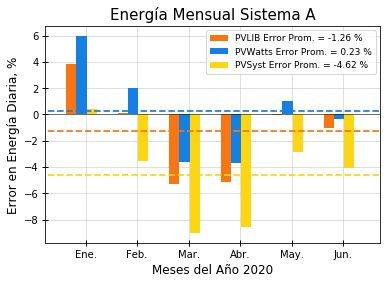

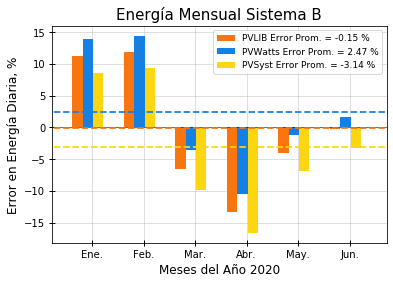

In [70]:
#Energy Error Comparison Plot
plt.style.use('fast')
x = np.arange(len(days))

#System A Figure
fig1, ax1 = plt.subplots();

#Mean Error Values
meanerror_PVLIB = round(energyerror_SysA['Error PVLIB, %'].mean(), 2)
meanerror_PVW = round(energyerror_SysA['Error PVWatts, %'].mean(), 2)
meanerror_PVS = round(energyerror_SysA['Error PVSyst, %'].mean(), 2)

plt.bar(r1, energyerror_SysA['Error PVLIB, %'], width, label='PVLIB Error Prom. = ' + f'{meanerror_PVLIB}' + ' %', color='#F87510', linewidth=2);
plt.bar(r3, energyerror_SysA['Error PVWatts, %'], width, label='PVWatts Error Prom. = ' + f'{meanerror_PVW}' + ' %', color='#1580E4', linewidth=2);
plt.bar(r5, energyerror_SysA['Error PVSyst, %'], width, label='PVSyst Error Prom. = ' + f'{meanerror_PVS}' + ' %', color='#FCD610', linewidth=2);

#Horizontal Lines
plt.hlines(y=0, xmin=-1, xmax=x[-1]+1, colors='black', linestyles='solid', label='', linewidth=0.5) #Zero
plt.hlines(y=meanerror_PVLIB, xmin=-1, xmax=x[-1]+1, colors='#F87510', linestyles='--', label='', linewidth=1.75) #PVLIB
plt.hlines(y=meanerror_PVW, xmin=-1, xmax=x[-1]+1, colors='#1580E4', linestyles='--', label='', linewidth=1.75) #PVWatts
plt.hlines(y=meanerror_PVS, xmin=-1, xmax=x[-1]+1, colors='#FCD610', linestyles='--', label='', linewidth=1.75) #PVSyst

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Mensual Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Error en Energía Diaria, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Meses del Año {}'.format(start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width + width/2.5, int_months)
plt.ylim(None, None)
plt.xlim(-0.5, 6)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO5_Energy_Error_SysA.eps', bbox_inches='tight')


#System B Figure
fig2, ax2 = plt.subplots();

#Mean Error Values
meanerror_PVLIB = round(energyerror_SysB['Error PVLIB, %'].mean(), 2)
meanerror_PVW = round(energyerror_SysB['Error PVWatts, %'].mean(), 2)
meanerror_PVS = round(energyerror_SysB['Error PVSyst, %'].mean(), 2)

plt.bar(r1, energyerror_SysB['Error PVLIB, %'], width, label='PVLIB Error Prom. = ' + f'{meanerror_PVLIB}' + ' %', color='#F87510', linewidth=2);
plt.bar(r3, energyerror_SysB['Error PVWatts, %'], width, label='PVWatts Error Prom. = ' + f'{meanerror_PVW}' + ' %', color='#1580E4', linewidth=2);
plt.bar(r5, energyerror_SysB['Error PVSyst, %'], width, label='PVSyst Error Prom. = ' + f'{meanerror_PVS}' + ' %', color='#FCD610', linewidth=2);

#Horizontal Lines
plt.hlines(y=0, xmin=-1, xmax=x[-1]+1, colors='black', linestyles='solid', label='', linewidth=0.5) #Zero
plt.hlines(y=meanerror_PVLIB, xmin=-1, xmax=x[-1]+1, colors='#F87510', linestyles='--', label='', linewidth=1.75) #PVLIB
plt.hlines(y=meanerror_PVW, xmin=-1, xmax=x[-1]+1, colors='#1580E4', linestyles='--', label='', linewidth=1.75) #PVWatts
plt.hlines(y=meanerror_PVS, xmin=-1, xmax=x[-1]+1, colors='#FCD610', linestyles='--', label='', linewidth=1.75) #PVSyst

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energía Mensual Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Error en Energía Diaria, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Meses del Año {}'.format(start.year), fontname="Helvetica", fontsize=12);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width + width/2.5, int_months)
plt.ylim(None, None)
plt.xlim(-0.5, 6)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO5_Energy_Error_SysB.eps', bbox_inches='tight')

### 2.5. Irradiance vs. AC Power

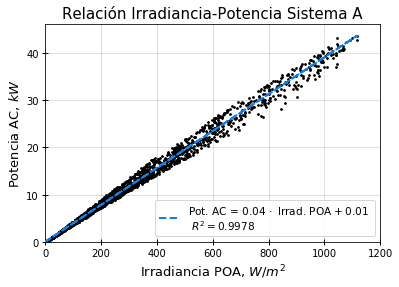

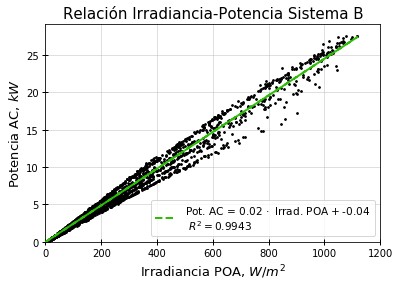

In [71]:
#System A
#Least Squares Linear Regression
x_value = measured_irrad['New Meteo. Irrad., W/m2']
y_value = ACPow_SysA['AC Power']

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 1200

#x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Pot. AC = " + f"{slope_SysA.round(2)} $· \:$ Irrad. POA $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_irrad['New Meteo. Irrad., W/m2'], ACPow_SysA['AC Power'], color='black', marker='o', s=3)

y = x
#plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Relación Irradiancia-Potencia Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Potencia AC, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Irradiancia POA, $W/m^2$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, None);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO6_IrradPot_SysA_Mes.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_irrad['New Meteo. Irrad., W/m2']
y_value = ACPow_SysB['AC Power']

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 1200

#x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Pot. AC = " + f"{slope_SysB.round(2)} $· \:$ Irrad. POA $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_irrad['New Meteo. Irrad., W/m2'], ACPow_SysB['AC Power'], color='black', marker='o', s=3)

y = x
#plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Relación Irradiancia-Potencia Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Potencia AC, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Irradiancia POA, $W/m^2$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, None);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO6_IrradPot_SysB_Mes.eps', bbox_inches='tight')

### 2.6. Normalised Efficiency

Based on *Funciones de Conversión para Plantas Eólicas y Solares* from CNO and Los Andes University.

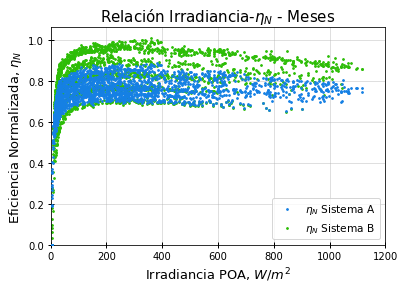

In [72]:
#STC Nameplate Power of PV Array [kWp]
Pstc_SysA = (module['V_mp_ref']*mps_SysA)*(module['I_mp_ref']*spi_SysA)/kilo
Pstc_SysB = (module['V_mp_ref']*mps_SysB)*(module['I_mp_ref']*spi_SysB)/kilo

#STC Irradiance [W/m2]
Gstc = 1000

#Normalized Instantaneous PV Array Efficiency
etaN_SysA = (ACPow_SysA['AC Power']/Pstc_SysA)/(measured_irrad['New Meteo. Irrad., W/m2']/Gstc)
etaN_SysA = etaN_SysA.fillna(0);

etaN_SysB = (ACPow_SysB['AC Power']/Pstc_SysB)/(measured_irrad['New Meteo. Irrad., W/m2']/Gstc)
etaN_SysB = etaN_SysB.fillna(0);

#Plot
fig1, ax1 = plt.subplots();
axis_lim = 1200

plt.scatter(measured_irrad['New Meteo. Irrad., W/m2'], etaN_SysA, label='$\eta_N$ Sistema A', color='#1580E4', marker='o', s=3, zorder=5)
plt.scatter(measured_irrad['New Meteo. Irrad., W/m2'], etaN_SysB, label='$\eta_N$ Sistema B', color='#2DBD07', marker='o', s=3)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Relación Irradiancia-$\eta_N$ - Meses', fontname="Helvetica", fontsize=15);
plt.ylabel('Eficiencia Normalizada, $\eta_N$', fontname="Helvetica", fontsize=13);
plt.xlabel('Irradiancia POA, $W/m^2$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, None); #Must be up to 1.
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO7_etaN_Mes.eps', bbox_inches='tight')

##### 2.6.1. Monthly Normalised AC Power vs. Temperature Correction

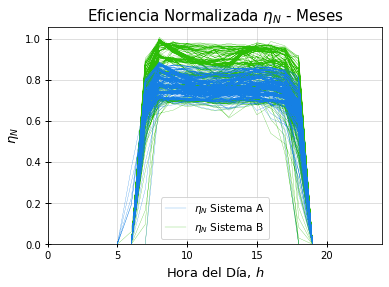

In [73]:
#Plot
fig1, ax1 = plt.subplots();
axis_lim = None

plt.plot(measured_irrad['Hour'], etaN_SysA, label='$\eta_N$ Sistema A', color='#1580E4', linewidth=0.25, zorder=5)
plt.plot(measured_irrad['Hour'], etaN_SysB, label='$\eta_N$ Sistema B', color='#2DBD07', linewidth=0.25)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Eficiencia Normalizada $\eta_N$ - Meses', fontname="Helvetica", fontsize=15);
plt.ylabel('$\eta_N$', fontname="Helvetica", fontsize=13);
plt.xlabel('Hora del Día, $h$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, 24);
plt.ylim(0, None); #Must be up to 1.
plt.grid(True);
plt.legend(fontsize=10.5, loc='best');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO7_etaN_Mes_Line.eps', bbox_inches='tight')

##### 2.6.2. One-Day Normalised AC Power vs. Temperature Correction

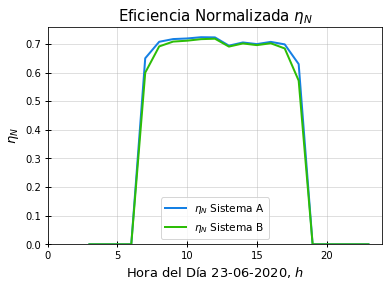

In [74]:
#STC Nameplate Power of PV Array [kWp]
Pstc_SysA = (module['V_mp_ref']*mps_SysA)*(module['I_mp_ref']*spi_SysA)/kilo
Pstc_SysB = (module['V_mp_ref']*mps_SysB)*(module['I_mp_ref']*spi_SysB)/kilo

#STC Irradiance [W/m2]
Gstc = 1000

#Normalized Instantaneous PV Array Efficiency
etaN_SysA = (ACPow_SysA['AC Power'][4178:4199]/Pstc_SysA)/(measured_irrad['New Meteo. Irrad., W/m2'][4178:4199]/Gstc)
etaN_SysA = etaN_SysA.fillna(0);

etaN_SysB = (ACPow_SysB['AC Power'][4178:4199]/Pstc_SysB)/(measured_irrad['New Meteo. Irrad., W/m2'][4178:4199]/Gstc)
etaN_SysB = etaN_SysB.fillna(0);

#Plot
#System A
fig1, ax1 = plt.subplots();
axis_lim = None

plt.plot(measured_irrad['Hour'][4178:4199], etaN_SysA, label='$\eta_N$ Sistema A', color='#1580E4', linewidth=2)
plt.plot(measured_irrad['Hour'][4178:4199], etaN_SysB, label='$\eta_N$ Sistema B', color='#2DBD07', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Eficiencia Normalizada $\eta_N$', fontname="Helvetica", fontsize=15);
plt.ylabel('$\eta_N$', fontname="Helvetica", fontsize=13);
plt.xlabel('Hora del Día {}-0{}-{}, $h$'.format(measured_irrad['Day'][4178], measured_irrad['Month'][4178], start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, 24);
plt.ylim(0, None);
plt.grid(True);
plt.legend(fontsize=10.5, loc='best');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO7_etaN_Dia_Line.eps', bbox_inches='tight')

### 2.7. Irradiance vs. Normalised AC Power

Based on *Funciones de Conversión para Plantas Eólicas y Solares* from CNO and Los Andes University.

In [75]:
etaN_SysA = (ACPow_SysA['AC Power']/Pstc_SysA)/(measured_irrad['New Meteo. Irrad., W/m2']/Gstc)
etaN_SysB = (ACPow_SysB['AC Power']/Pstc_SysB)/(measured_irrad['New Meteo. Irrad., W/m2']/Gstc)

#STC Irradiance [ºC]
Tstc = 25

#Temperature-Corrected
Tcorr = 1 + module['gamma_pdc']*(measured_modtemp['Modules Temp., °C']-Tstc)

#Normalized Temperature-Corrected Modeled AC Power
Pac_norm_SysA = etaN_SysA*measured_irrad['New Meteo. Irrad., W/m2']*(Pstc_SysA/Gstc)
Pac_norm_SysA = Pac_norm_SysA.fillna(0);

Pac_norm_SysB = etaN_SysB*measured_irrad['New Meteo. Irrad., W/m2']*(Pstc_SysB/Gstc)
Pac_norm_SysB = Pac_norm_SysB.fillna(0);

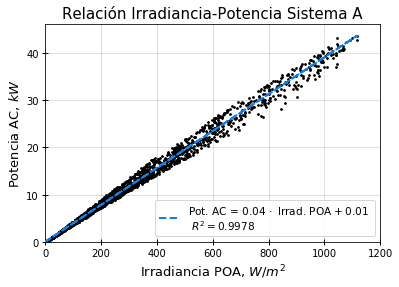

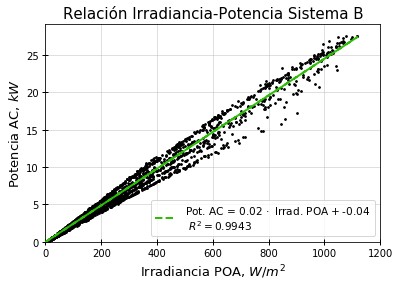

In [76]:
#System A
#Least Squares Linear Regression
x_value = measured_irrad['New Meteo. Irrad., W/m2']
y_value = Pac_norm_SysA

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 1200

#x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Pot. AC = " + f"{slope_SysA.round(2)} $· \:$ Irrad. POA $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_irrad['New Meteo. Irrad., W/m2'], Pac_norm_SysA, color='black', marker='o', s=3)

y = x
#plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Relación Irradiancia-Potencia Sistema A', fontname="Helvetica", fontsize=15);
plt.ylabel('Potencia AC, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Irradiancia POA, $W/m^2$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, None);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO7_IrradPot_SysA_Mes.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_irrad['New Meteo. Irrad., W/m2']
y_value = Pac_norm_SysB

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 1200

#x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Pot. AC = " + f"{slope_SysB.round(2)} $· \:$ Irrad. POA $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_irrad['New Meteo. Irrad., W/m2'], Pac_norm_SysB, color='black', marker='o', s=3)

y = x
#plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Relación Irradiancia-Potencia Sistema B', fontname="Helvetica", fontsize=15);
plt.ylabel('Potencia AC, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Irradiancia POA, $W/m^2$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, None);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('/Users/nelsonsasa07/Documents/PV Simulations/CNO/Fig/CNO7_IrradPot_SysB_Mes.eps', bbox_inches='tight')

___